### Background

The transaction data is over a period of 14 months, running from the start of July 2021 to the end of August 2022. There are 5144 customers and 46926 unique accounts, with some customers having more than one account. The number of transactions per customer range from 1 to just over 2 000 for the 14-month period.

The train set contains 3600 customers along with their declared net income and the test data contains the remaining 1544 customers with the declared income excluded.

Along with the train and test files is the transaction history for each customer which details the various transactions each customer engaged in over the entire period of recording. There are also data files containing demographic information on each customer as well as files describing some of the categorical variables related to the customers.

### Install Additional Dependencies
The python 3 (ipykernal) from Sagemaker Studio Jupyterlab comes with quite a few packages by default. We added additionl installations.


In [182]:
# !pip install seaborn
# !pip install shap 
# !pip install scikit-optimize
# !pip install awswrangler

In [1]:
import sagemaker 

import pandas as pd
import awswrangler as wr
import numpy as np
import math
import re
from datetime import datetime
import joblib
import os

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from scipy.stats import gamma

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score, root_mean_squared_error

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor

import shap
from skopt import BayesSearchCV

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
default_bucket = sagemaker_session.default_bucket()

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 17, 8

In [4]:
s3_prefix = "absa_zindi_challenge"
input_s3_path = os.path.join("s3://", default_bucket, s3_prefix, "input-data")
artifacts_s3_path = os.path.join("s3://", default_bucket, s3_prefix, "artifacts")
submissions_s3_path = os.path.join("s3://", default_bucket, s3_prefix, "submissions")

### 2. Exploratory Data Analysis

### Examining the train set
`train.csv` Contains customer identifiers as well as record dates for customers in the train set. 

In [5]:
train_df = wr.s3.read_csv(os.path.join(input_s3_path, "Train.csv"), thousands=r',')

2025-01-19 11:52:34,173	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 904863744 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.15gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-01-19 11:52:35,464	INFO worker.py:1786 -- Started a local Ray instance.


In [6]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CUSTOMER_IDENTIFIER  3600 non-null   object
 1   RECORD_DATE          3600 non-null   object
 2   DECLARED_NET_INCOME  3600 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 84.5+ KB


,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07,13500
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04,9000
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06,8000
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08,7000
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07,10400


The training dataset consists of 3,600 records. The `customer_identifier` column is assumed to uniquely identify each customer, while the `record_month` column likely represents the date when the declared income was recorded. No missing values are evident in the data.

#### Net income (The Target Variable)

In [7]:
train_df['DECLARED_NET_INCOME'].describe()

count     3600.000000
mean     13969.916667
std      10244.416366
min       1300.000000
25%       7000.000000
50%      11100.000000
75%      18100.000000
max      95600.000000
Name: DECLARED_NET_INCOME, dtype: float64

The declared income ranges from R1,300 to R95,600, with an average of R13,970 and a median of R11,100. The median being lower than the mean suggests that the data is positively skewed, indicating that a larger number of individuals earn below the average, while fewer individuals with higher incomes raise the mean.


In [8]:
print(f"The coefficient of skewness is {train_df['DECLARED_NET_INCOME'].skew():.2f}")

The coefficient of skewness is 2.53


The coefficient of skewness for the data is 2.53, indicating a strong positive skew. This prompted us to plot the distribution of income and fit a theoretical gamma distribution to better understand the data's underlying structure.

In [9]:
# Known mean and standard deviation
mean =train_df['DECLARED_NET_INCOME'].mean()
std_dev = train_df['DECLARED_NET_INCOME'].std()

# Calculate shape (alpha) and scale (beta)
alpha = (mean ** 2) / (std_dev ** 2)
beta = (std_dev ** 2) / mean

print(f"The mean declared net income {mean}")
print(f"The stddev declared net income {std_dev}")
print(f"Shape (alpha): {alpha}")
print(f"Scale (beta): {beta}")

# Generate the gamma distribution
x = np.linspace(train_df['DECLARED_NET_INCOME'].min(), train_df['DECLARED_NET_INCOME'].max(),  1000)  # Range of values for the PDF
pdf = gamma.pdf(x, a=alpha, scale=beta)

The mean declared net income 13969.916666666666
The stddev declared net income 10244.416365915822
Shape (alpha): 1.8595728139703604
Scale (beta): 7512.433265164594


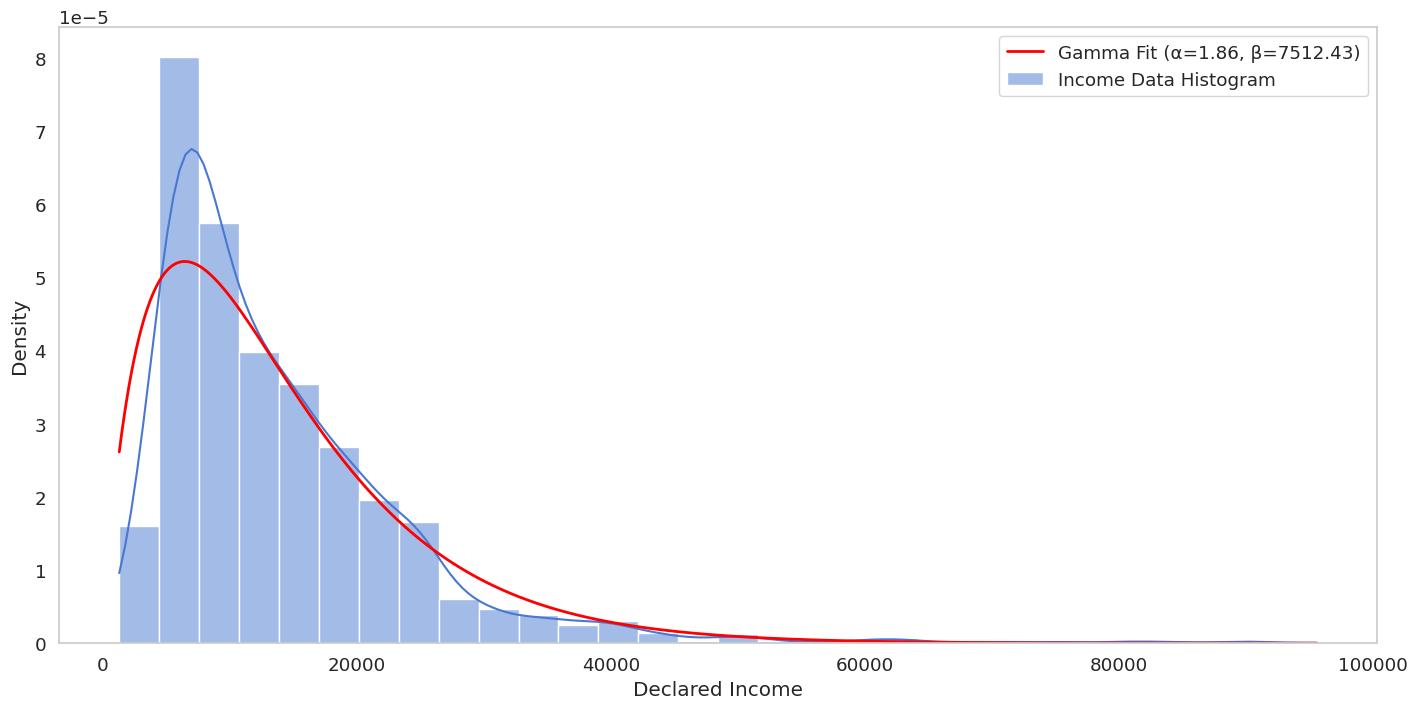

In [10]:
sns.histplot(train_df['DECLARED_NET_INCOME'], kde=True, stat='density', bins=30, label="Income Data Histogram")
plt.plot(x, pdf, color='red',lw=2, label=f"Gamma Fit (α={alpha:.2f}, β={beta:.2f})")
plt.xlabel("Declared Income")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

The theoretical gamma distribution appears to align with the general shape of the income distribution; however, it tends to understate the peak compared to the actual data distribution.


#### Record-Month 

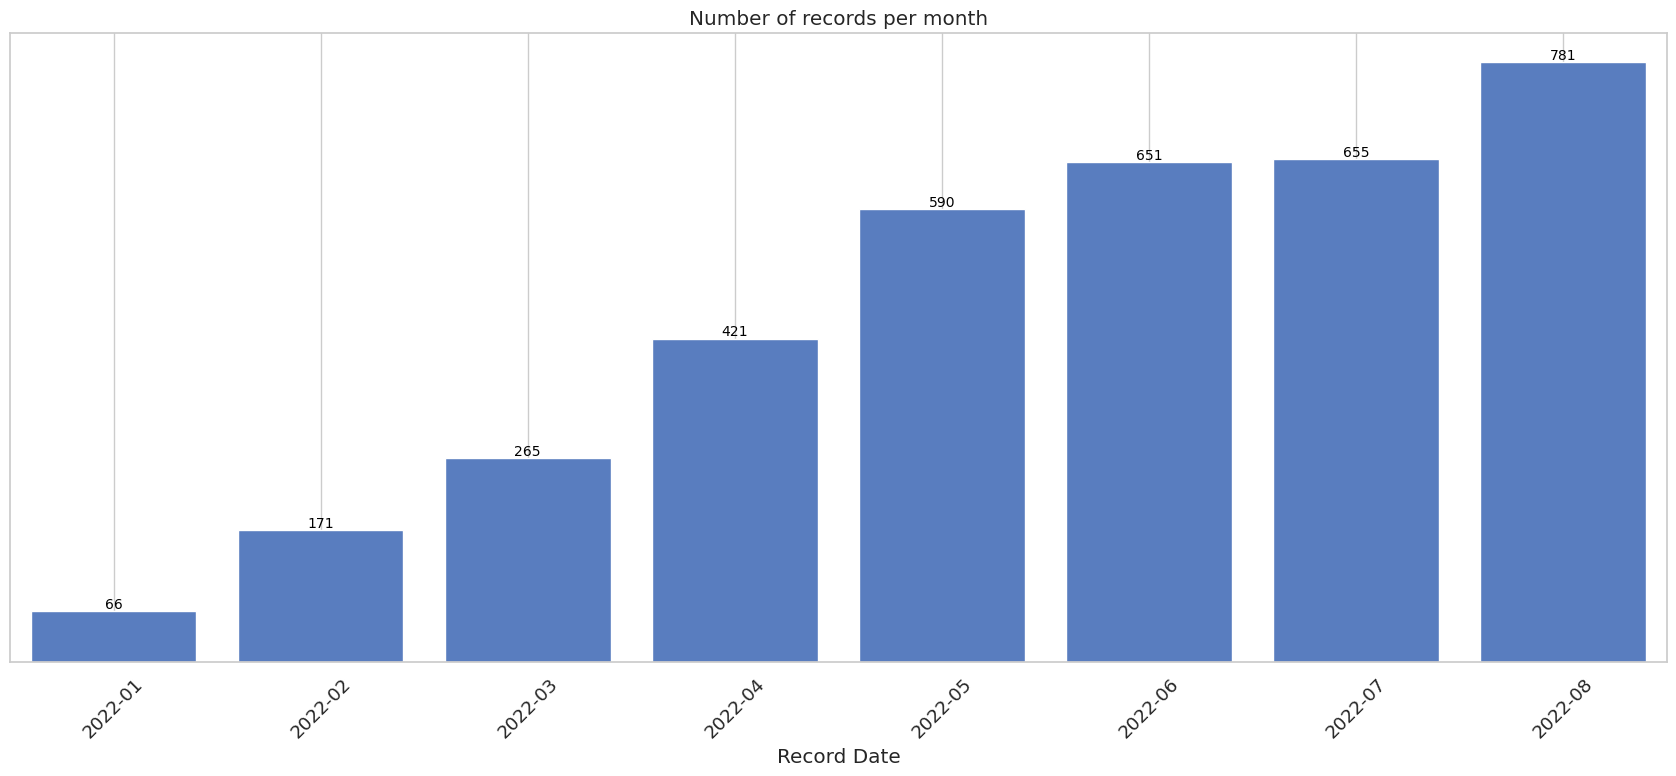

In [11]:
record_date_counts = train_df['RECORD_DATE'].value_counts().sort_index()
# Create the barplot
ax = sns.barplot(x=record_date_counts.index, y=record_date_counts.values)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Customize the plot
plt.title("Number of records per month")
plt.xlabel("Record Date")
ax.get_yaxis().set_visible(False)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.grid()
plt.show()

The data spans across 8 months, from January to September 2022. It appears that more records are being added as the months progress. This trend raises the question of whether there was a selection criterion that more individuals met as the months advanced, leading to the increase in the number of records. Further investigation is required to determine if this is due to changing eligibility criteria or other factors influencing record inclusion over time. 

#### Record Identifiers

In [12]:
print(f"The number of unique customers in the training dataset {train_df.CUSTOMER_IDENTIFIER.nunique()}")

The number of unique customers in the training dataset 3600


This matches the total number of records in the dataset, providing further confirmation that the customer_identifier serves as the primary key in the train dataset.

#### Record date vs Declared Income

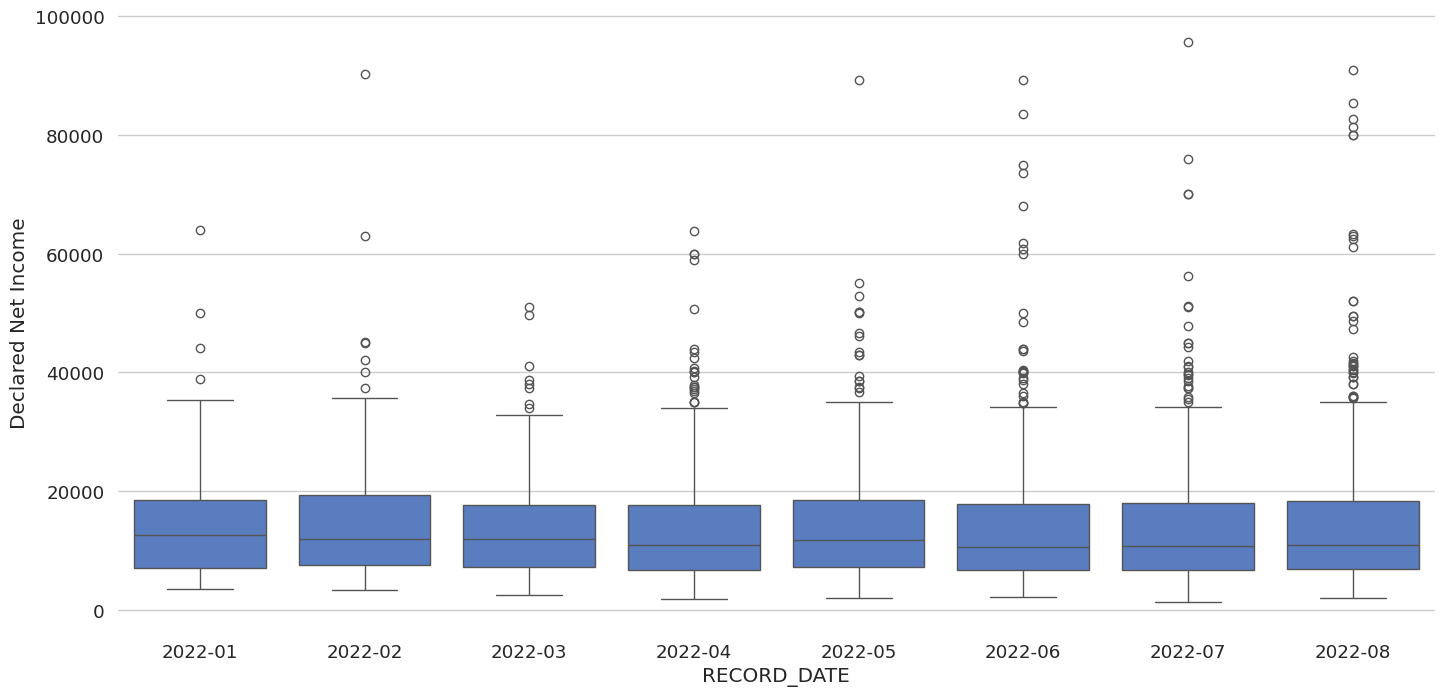

In [13]:
sns.boxplot(data = train_df,
            x='RECORD_DATE',
            y='DECLARED_NET_INCOME',
            order = np.unique(train_df['RECORD_DATE'])
           )
plt.ylabel("Declared Net Income")
plt.box()
plt.show()

Examining the box plots reveals slight fluctuations in the median income, with January showing a slightly higher median compared to the other months. The later months exhibit more extreme income values. In the first four months, only one month recorded incomes above R80,000, while in the following four months, every month had incomes exceeding R80,000.

### Customer Information Analysis

In [14]:
customer_df =  wr.s3.read_csv(os.path.join(input_s3_path, "customer.csv"))
customer_df.info()
customer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   CUSTOMER_IDENTIFIER       5144 non-null   object
 1   DATE_LAST_UPDATED         5144 non-null   object
 2   SEX_CODE                  5144 non-null   int64 
 3   INCOME_GROUP_CODE         5144 non-null   int64 
 4   NUMBER_OF_ACCOUNTS        5144 non-null   int64 
 5   OCCUPATIONAL_STATUS_CODE  5144 non-null   int64 
 6   AGE                       5144 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 281.4+ KB


,CUSTOMER_IDENTIFIER,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
0,ID_00a7d65f82a6819e79c29a84e805777f0265308b655...,2022-09,1,6,4,7,51
1,ID_09651edcac6c55a5e401062b0c0ef7bbba3f3e49538...,2022-09,0,7,10,3,32
2,ID_17215674e76eb33b47c4dd3ac3392e3e8f1a34b131b...,2022-09,1,7,7,1,41
3,ID_212860dd16c79ea8eae97cc1fc181e6afd4862fceaf...,2022-09,0,13,10,1,44
4,ID_24953f74da44bd0915c4cb78c1d97cbbd66e85bbd91...,2022-08,0,13,6,1,44



**Total Entries**: 5144  
**Columns**: 7  
**Data Types**:
- **int64**: 5 columns
- **object**: 2 columns
**Memory Usage**: 281.4 KB

#### Columns Breakdown

1. **CUSTOMER_IDENTIFIER** (dtype: object)
   - Non-null count: 5144
   - Type: Alphanumeric identifiers for customers.
   - Example: `ID_00a7d65f82a6819e79c29a84e805777f0265308b655...`
  
2. **DATE_LAST_UPDATED** (dtype: object)
   - Non-null count: 5144
   - Type: Date in `YYYY-MM` format.
   - Example: `2022-09`

3. **SEX_CODE** (dtype: int64)
   - Non-null count: 5144
   - Type: Numeric encoding of gender.
     - The values are `[0,1]` and there is no additional data to get the meanings.

4. **INCOME_GROUP_CODE** (dtype: int64)
   - Non-null count: 5144
   - Type: Numeric encoding of income groups.
     - The meaning of codes (e.g., `6`, `7`, `13`) a dimension table containing descriptions has been supplied.

5. **NUMBER_OF_ACCOUNTS** (dtype: int64)
   - Non-null count: 5144
   - Type: Numeric count of accounts per customer.

6. **OCCUPATIONAL_STATUS_CODE** (dtype: int64)
   - Non-null count: 5144
   - Type: Numeric encoding for occupational status.
     - Example: `7`, `3`, `1`.
     - employment_status table supplied to decode this.

7. **AGE** (dtype: int64)
   - Non-null count: 5144
   - Type: Age of the customer.


In [15]:
print(f"The number of unique customers {customer_df['CUSTOMER_IDENTIFIER'].nunique()}")

The number of unique customers 5144


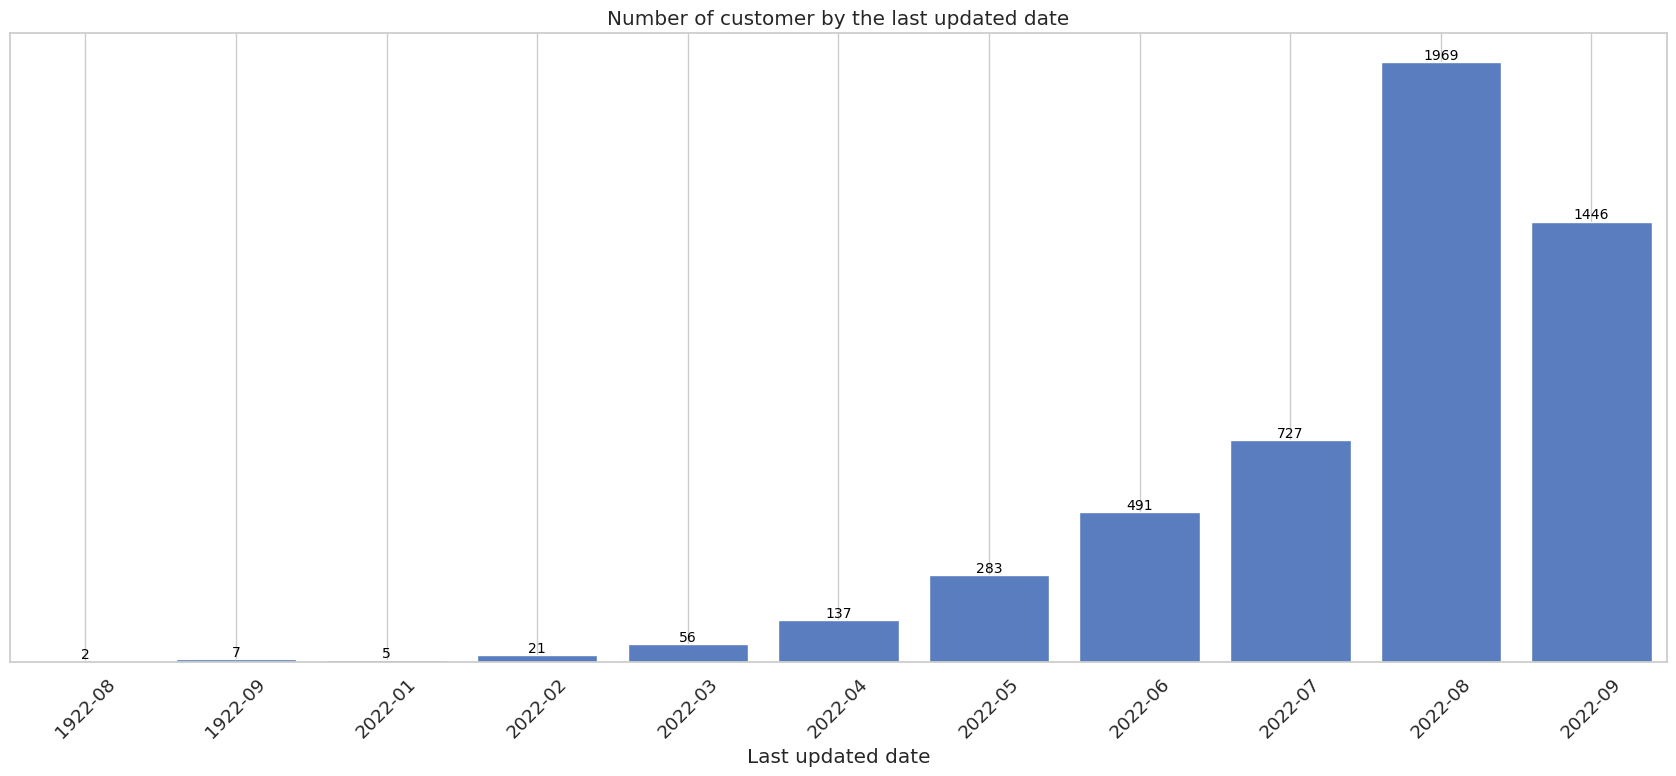

In [16]:
record_date_counts = customer_df["DATE_LAST_UPDATED"].value_counts().sort_index()
# Create the barplot
ax = sns.barplot(x=record_date_counts.index, y=record_date_counts.values)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Customize the plot
plt.title("Number of customer by the last updated date")
plt.xlabel("Last updated date")
ax.get_yaxis().set_visible(False)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.grid()
plt.show()


The data represents a time series of entries, with values recorded for each month from **1922-08** to **2022-09**. Here's a summary of the counts per month:

- **Early data** (1922-08, 1922-09): Very few entries, with only **2** entries in **1922-08** and **7** entries in **1922-09**.
- **Starting from 2022-01**: The number of entries begins to rise significantly.
- **2022-02 to 2022-07**: The counts gradually increase, peaking at **727** in **2022-07**.
- **Major Increase in 2022-08 and 2022-09**: The most noticeable spikes occur in **2022-08** (**1969 entries**) and **2022-09** (**1446 entries**), with **2022-08** being the highest value recorded.

#### What Stands Out:
- **Significant increase in 2022**: The number of entries increases drastically starting from **2022-01**, with the highest counts in the **mid-2022 months** (especially in **2022-08** and **2022-09**).
- **Anomalous early dates**: The very low counts in **1922-08** and **1922-09** stand out as potential anomalies or data entry issues. 
- **Sharp peak in 2022-08**: There is an unusually sharp increase in **2022-08**, where the entries more than doubled compared to **2022-07**.







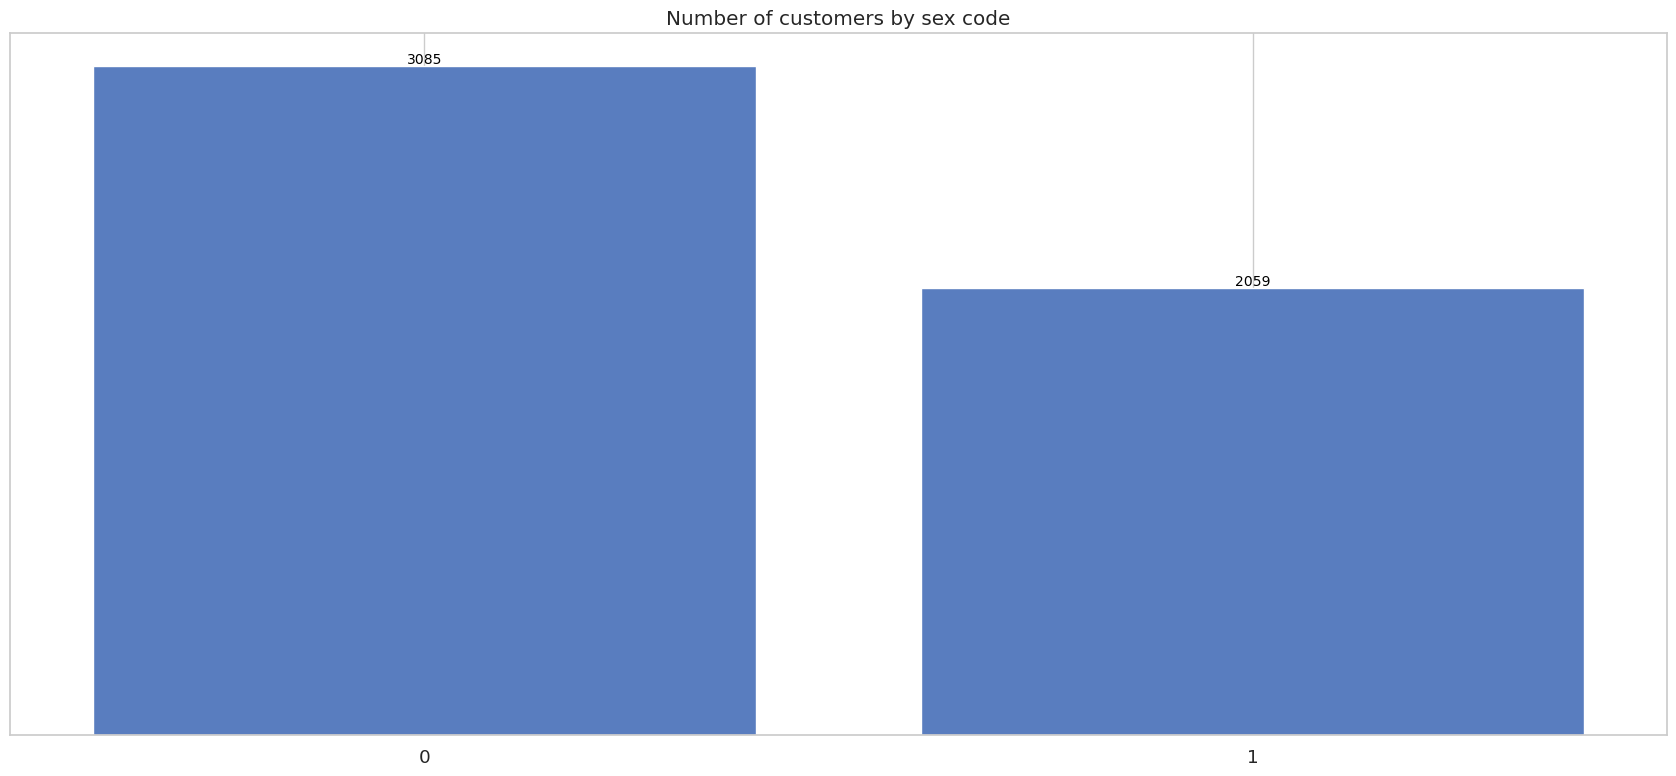

In [17]:
record_date_counts = customer_df["SEX_CODE"].value_counts().sort_index()
ax = sns.barplot(x=record_date_counts.index, y=record_date_counts.values)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Customize the plot
plt.title("Number of customers by sex code")
plt.xlabel("")
ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.grid()
plt.show()

There are significantly more customers in sex class 0 than in sex class 1, with 3,085 compared to 2,059—approximately 50% more.

#### Number of accounts

In [18]:
customer_df.NUMBER_OF_ACCOUNTS.describe()

count    5144.000000
mean        9.122473
std         4.144926
min         2.000000
25%         6.000000
50%         8.000000
75%        11.000000
max        38.000000
Name: NUMBER_OF_ACCOUNTS, dtype: float64

**Right Skew**: The data is likely right-skewed, as the **mean (9.12)** is greater than the **median (8)**. This suggests a longer tail on the right side of the distribution.<br>
**Interquartile Range (IQR)**: The middle 50% of customers have between **6 and 11 accounts**.<br>
**Range**: The number of accounts varies from **2 to 38**, with the maximum being quite large, indicating potential outliers or customers with a significantly higher number of accounts.


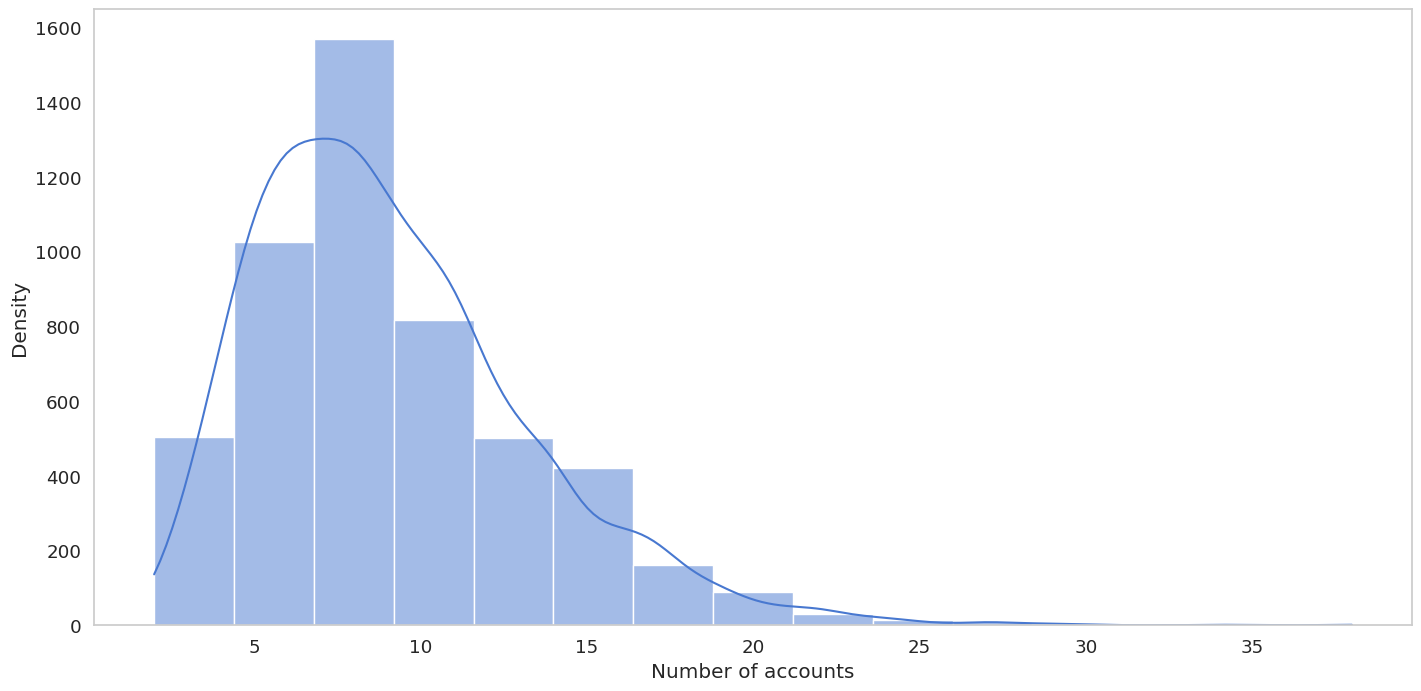

In [19]:
sns.histplot(customer_df["NUMBER_OF_ACCOUNTS"], kde=True, bins=15)
plt.xlabel("Number of accounts")
plt.ylabel("Density")
plt.grid()
plt.show()

In [20]:
print(f"The coefficient of skewness : {customer_df['NUMBER_OF_ACCOUNTS'].skew():.3f}")

The coefficient of skewness : 1.056


The histogran confirms our hypothesis regarding the skewness of the data. The skewness coefficient of 1.056 supports the conclusion that the data is moderately right-skewed.

In [21]:
employment_status_df =  wr.s3.read_csv(os.path.join(input_s3_path, "employment_status.csv"))
employment_status_df

,employee_status_code,employee_status_desc
0,0,Resigned
1,3,Active
2,1,Inactive
3,2,Retiree


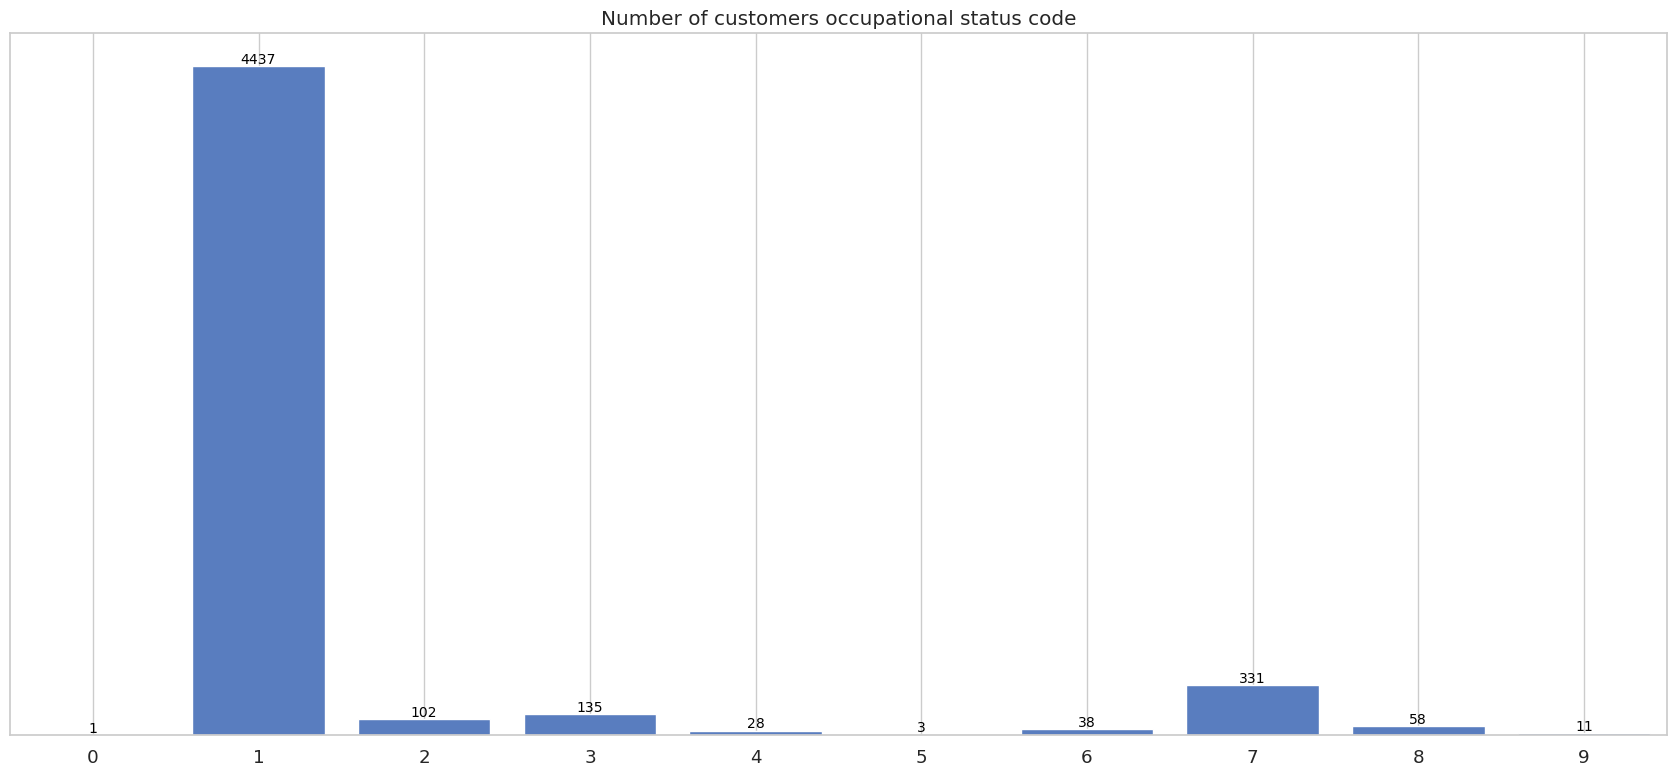

In [22]:
occupation_status_counts = customer_df.OCCUPATIONAL_STATUS_CODE.value_counts().sort_index()
ax = sns.barplot(x=occupation_status_counts.index, y=occupation_status_counts.values)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Customize the plot
plt.title("Number of customers occupational status code")
plt.xlabel("")
ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.grid()
plt.show()

#### Insights on occupational status
1. The employment status table contains 4 status codes, while the customer table includes 7 occupational status codes. If the employment status table is intended to serve as a lookup table for occupational codes, this discrepancy violates referential integrity. As a result, we will not proceed with joining these two tables.
2. The dataset contains 10 unique `OCCUPATIONAL_STATUS_CODE` values, each with a corresponding count.
3. Code `1` has the highest count (`4437`), dominating the dataset.
4. The other codes have significantly lower counts, ranging from `1` (code `0`) to `331` (code `7`).
5. The data is highly skewed, with code `1` accounting for the vast majority of the entries.
6. Codes `0`, `5`, and `9` have particularly low counts (`1`, `3`, and `11`, respectively).
7. Code `0` has only one occurrence, which might indicate an anomaly or an edge case.


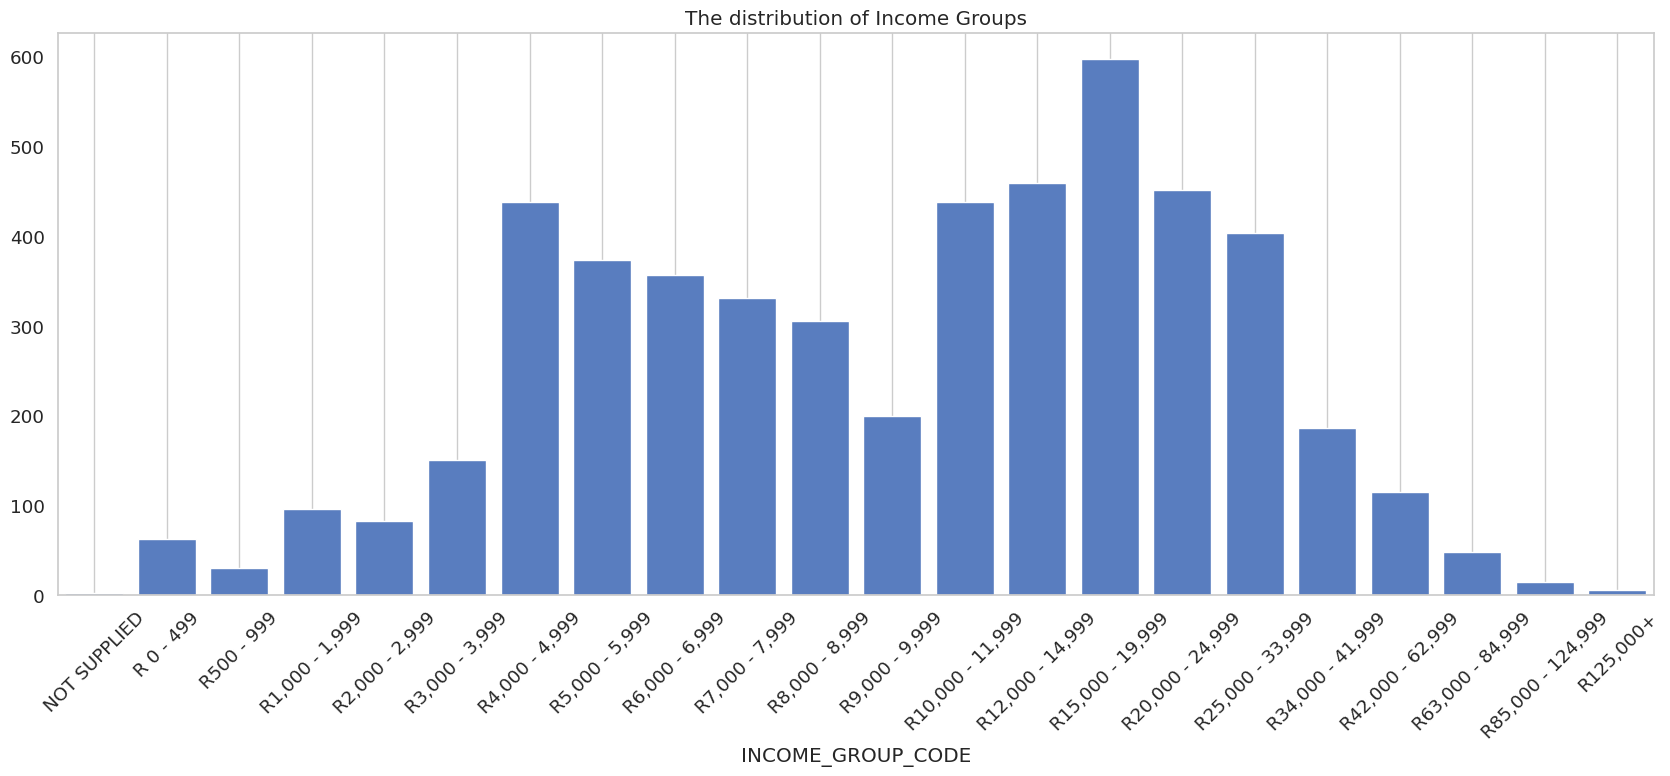

In [127]:
income_group_df =  wr.s3.read_csv(os.path.join(input_s3_path, "income_group.csv"))
income_map=dict(zip(income_group_df.income_group_code, income_group_df.income_group_desc))

income_group_counts = customer_df.INCOME_GROUP_CODE.value_counts().sort_index()
ax = sns.barplot(x=income_group_counts.index.map(income_map), y=income_group_counts.values)
plt.title("The distribution of Income Groups")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
customer_df['AGE'].describe()

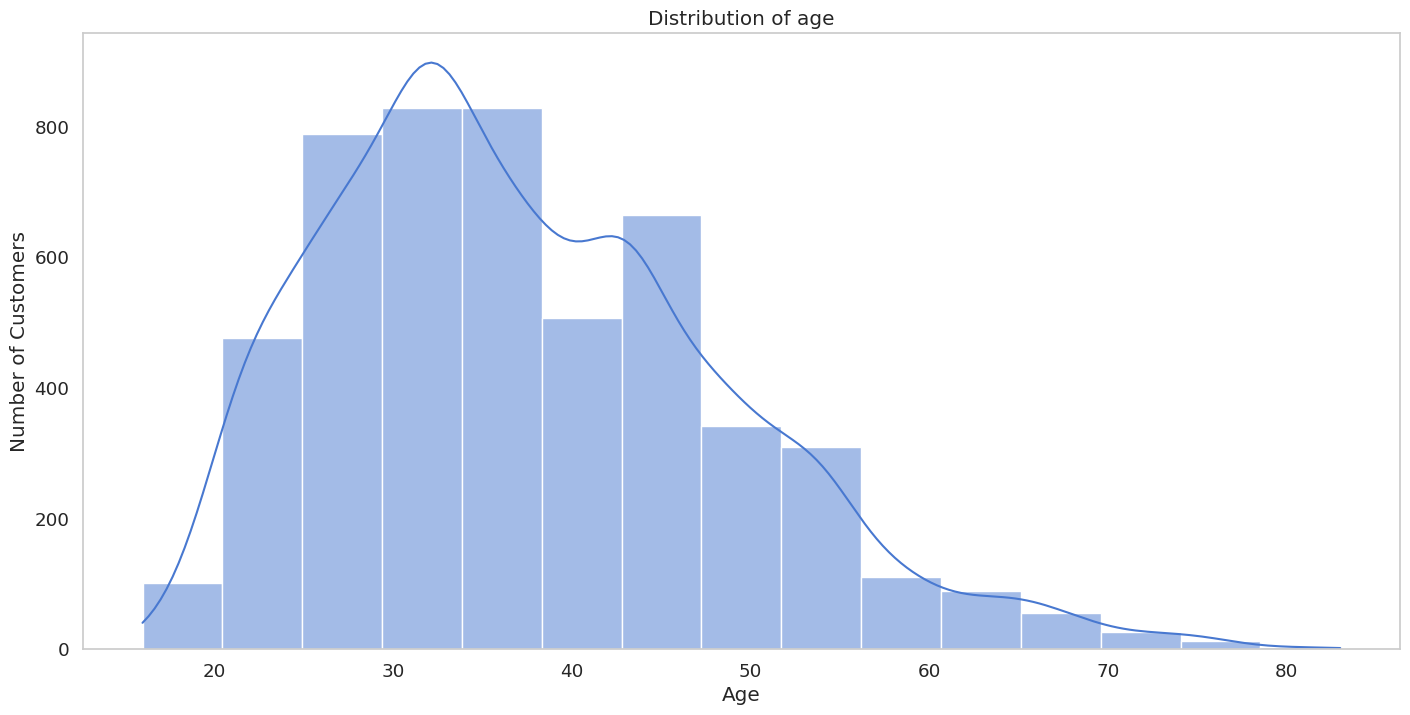

In [24]:
sns.histplot(customer_df['AGE'], kde=True, bins=15)
plt.title("Distribution of age")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.grid()
plt.show()

#### Insights on age
1. **Skewness**:
   - The distribution is slightly skewed to the right, with a long tail towards older ages.
   - This indicates that while most customers fall into younger and middle age brackets, there are fewer in older age groups.

2. **Dominant Age Range**:
   - The most common ages are between **25 and 40**, representing the majority of the population.

3. **Central Tendencies**:
   - **Mean Age**: 36
   - **Median Age**: 37
   - The closeness of the mean and median suggests that the data is not heavily skewed but leans slightly toward younger ages.

4. **Mid-40s Hump**:
   - A noticeable hump in the mid-40s indicates a secondary cluster of customers around this age, possibly linked to a specific segment or product appeal.

#### Merges customer information with the train set

In [25]:
train_cust_df = train_df.merge(customer_df, on='CUSTOMER_IDENTIFIER')
train_cust_df.info()
train_cust_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   CUSTOMER_IDENTIFIER       3600 non-null   object
 1   RECORD_DATE               3600 non-null   object
 2   DECLARED_NET_INCOME       3600 non-null   int64 
 3   DATE_LAST_UPDATED         3600 non-null   object
 4   SEX_CODE                  3600 non-null   int64 
 5   INCOME_GROUP_CODE         3600 non-null   int64 
 6   NUMBER_OF_ACCOUNTS        3600 non-null   int64 
 7   OCCUPATIONAL_STATUS_CODE  3600 non-null   int64 
 8   AGE                       3600 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 253.3+ KB


,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07,13500,2022-07,0,15,7,1,45
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04,9000,2022-04,0,15,5,1,32
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06,8000,2022-08,0,7,7,7,59
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08,7000,2022-08,1,9,14,7,57
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07,10400,2022-09,0,12,11,1,29


In [26]:
train_cust_df.groupby("SEX_CODE")["DECLARED_NET_INCOME"].describe().T

SEX_CODE,0,1
count,2145.000000,1455.000000
mean,14083.403263,13802.611684
std,10594.609944,9706.307245
min,1300.000000,1800.000000
25%,7000.000000,6800.000000
50%,10800.000000,11600.000000
75%,18000.000000,18400.000000
max,95600.000000,90300.000000


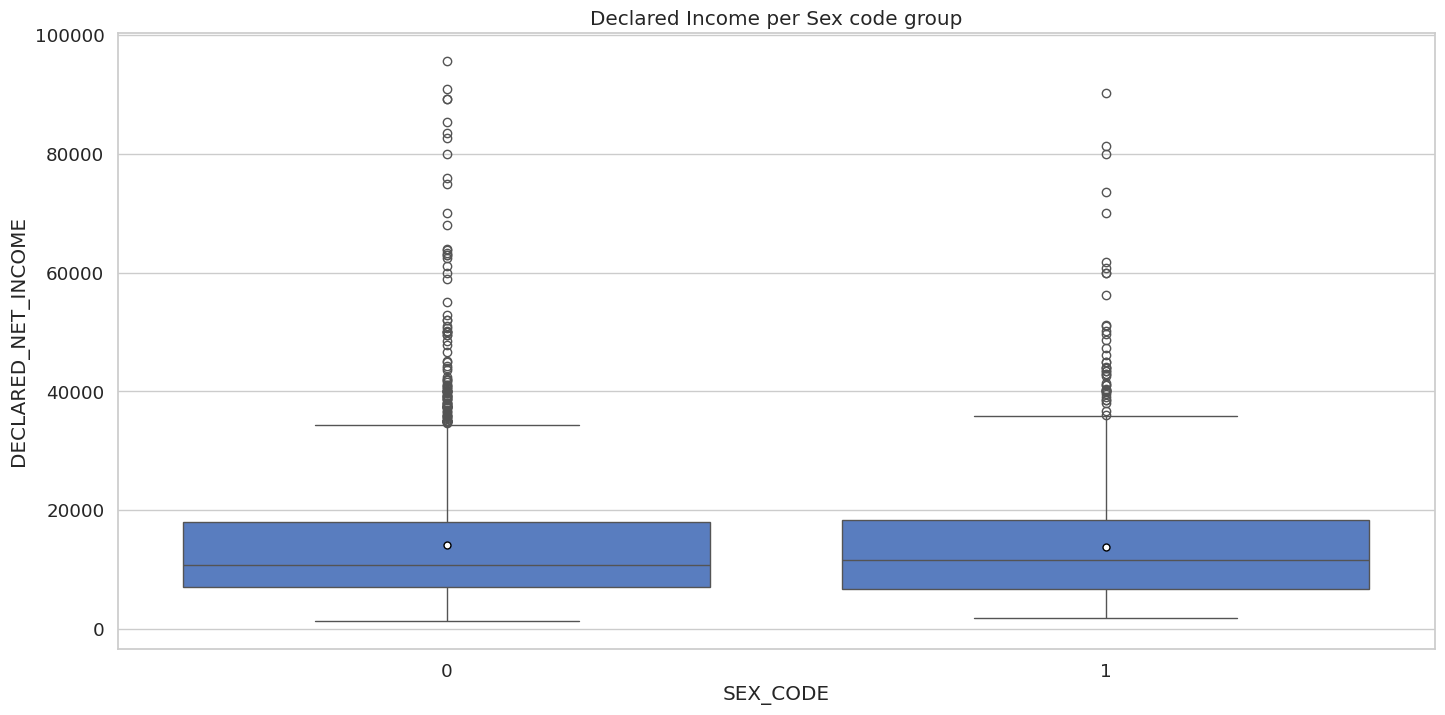

In [27]:
plt.title("Declared Income per Sex code group")
sns.boxplot(data = train_cust_df,
            x="SEX_CODE",
            y="DECLARED_NET_INCOME",
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"}
           )
plt.show()

1. **Population Sizes**:
   - There are more data points for `EX_CODE = 0` (2145) compared to `EX_CODE = 1` (1455).
   - The difference in sample sizes may impact comparative analyses.

2. **Mean and Median**:
   - The average value for `EX_CODE = 0` (14,083) is slightly higher than `EX_CODE = 1` (13,803).
   - The medians for both groups are close, with `EX_CODE = 0` at 10,800 and `EX_CODE = 1` at 11,600.

3. **Distribution Spread**:
   - Both categories show wide distributions with high standard deviations (`10,594.61` for `EX_CODE = 0` and `9,706.31` for `EX_CODE = 1`).
   - The ranges (difference between min and max) for both categories are large, suggesting significant variability.

4. **Minimum and Maximum**:
   - `EX_CODE = 0` has a slightly lower minimum (1,300 vs. 1,800) but a higher maximum (95,600 vs. 90,300), indicating a broader range.

5. **Quartiles**:
   - The 25th and 75th percentiles are similar between the two groups, but `EX_CODE = 1` shows slightly higher values in the upper quartile.


#### Merge train table to the income group 

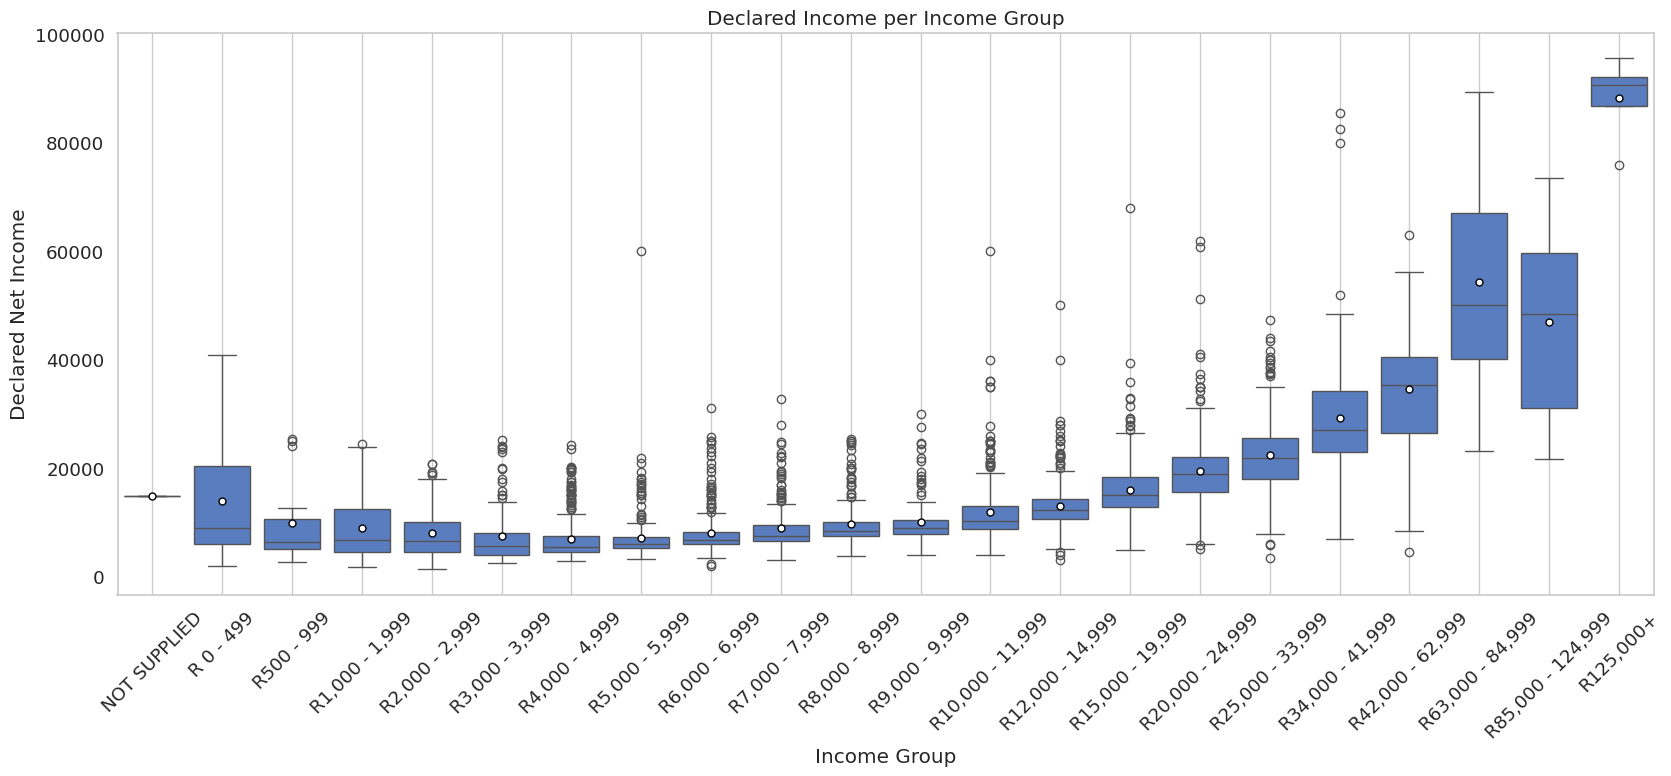

In [30]:
plt.title("Declared Income per Income Group")
sns.boxplot(x=train_cust_df.sort_values(by="INCOME_GROUP_CODE")["INCOME_GROUP_CODE"].map(income_map),
            y=train_cust_df.sort_values(by="INCOME_GROUP_CODE")["DECLARED_NET_INCOME"],
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"}
           )
plt.xlabel("Income Group")
plt.ylabel("Declared Net Income")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

#### Number of accounts vs Declared Income

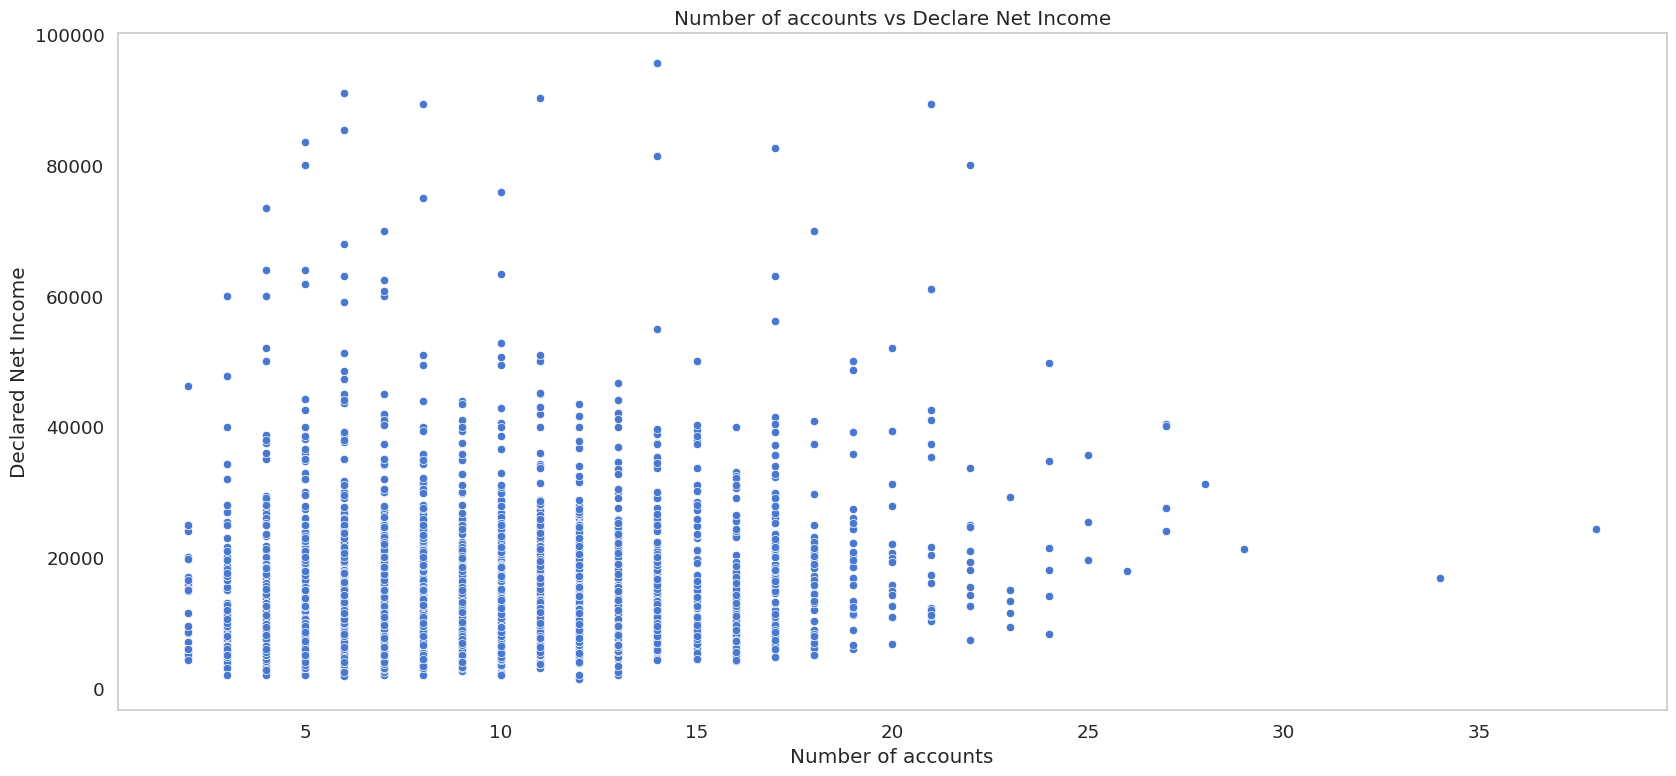

In [31]:
sns.scatterplot(data = train_cust_df, x="NUMBER_OF_ACCOUNTS", y = "DECLARED_NET_INCOME")
plt.title("Number of accounts vs Declare Net Income")
plt.grid()
plt.xlabel("Number of accounts")
plt.ylabel("Declared Net Income")
plt.tight_layout()
plt.show()

In [32]:
print(f"Pearson correlation between the declared income and number of accounts per customer {train_cust_df[['NUMBER_OF_ACCOUNTS', 'DECLARED_NET_INCOME']].corr().iloc[0,1]:.4f}")

Pearson correlation between the declared income and number of accounts per customer 0.1728


Both the scatterplot and the pearson correlation of 0.1728 suggest that there is not obvious relationship between the number of accounts and declared income.

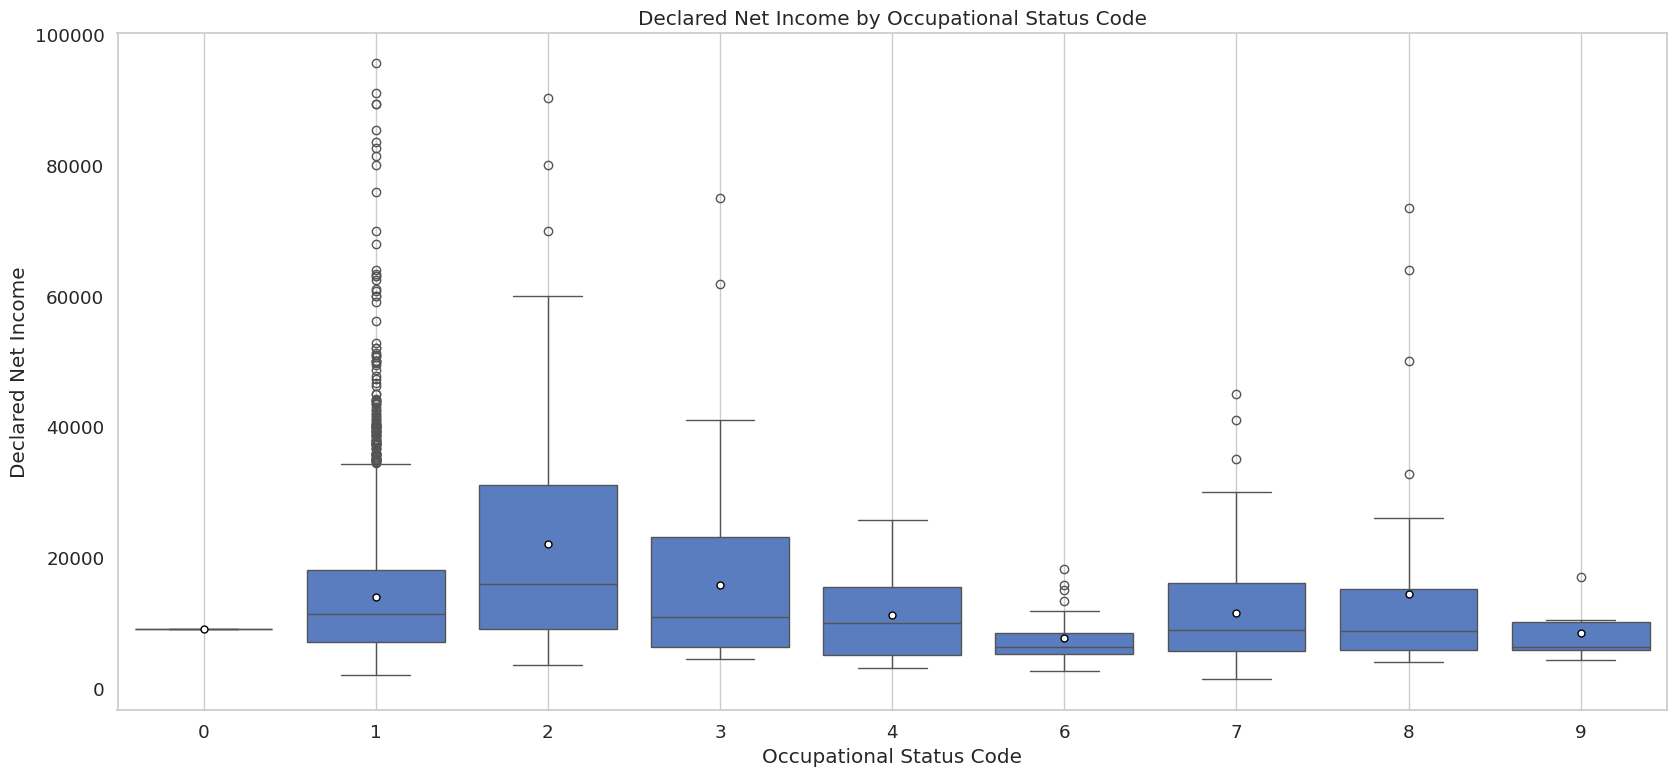

In [33]:
sns.boxplot(
    data=train_cust_df,
    x = "OCCUPATIONAL_STATUS_CODE",
    y = "DECLARED_NET_INCOME",
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
              "markersize":"5"}
   )
plt.xlabel("Occupational Status Code")
plt.ylabel("Declared Net Income")
plt.title("Declared Net Income by Occupational Status Code")
plt.grid()
plt.tight_layout()
plt.show();

Customers with occupational status code 2 tend to have higher declared net incomes compared to other groups, with the widest range of income variability. Occupational status code 1 exhibits a significant number of high-income outliers, suggesting the presence of individuals with exceptionally high declared earnings. Conversely, occupational status codes 6 and 9 show lower declared incomes relative to other groups, with a more concentrated distribution and fewer extreme values. Additionally, the interquartile range (IQR) varies across different codes, indicating differing levels of income consistency within each occupational category.

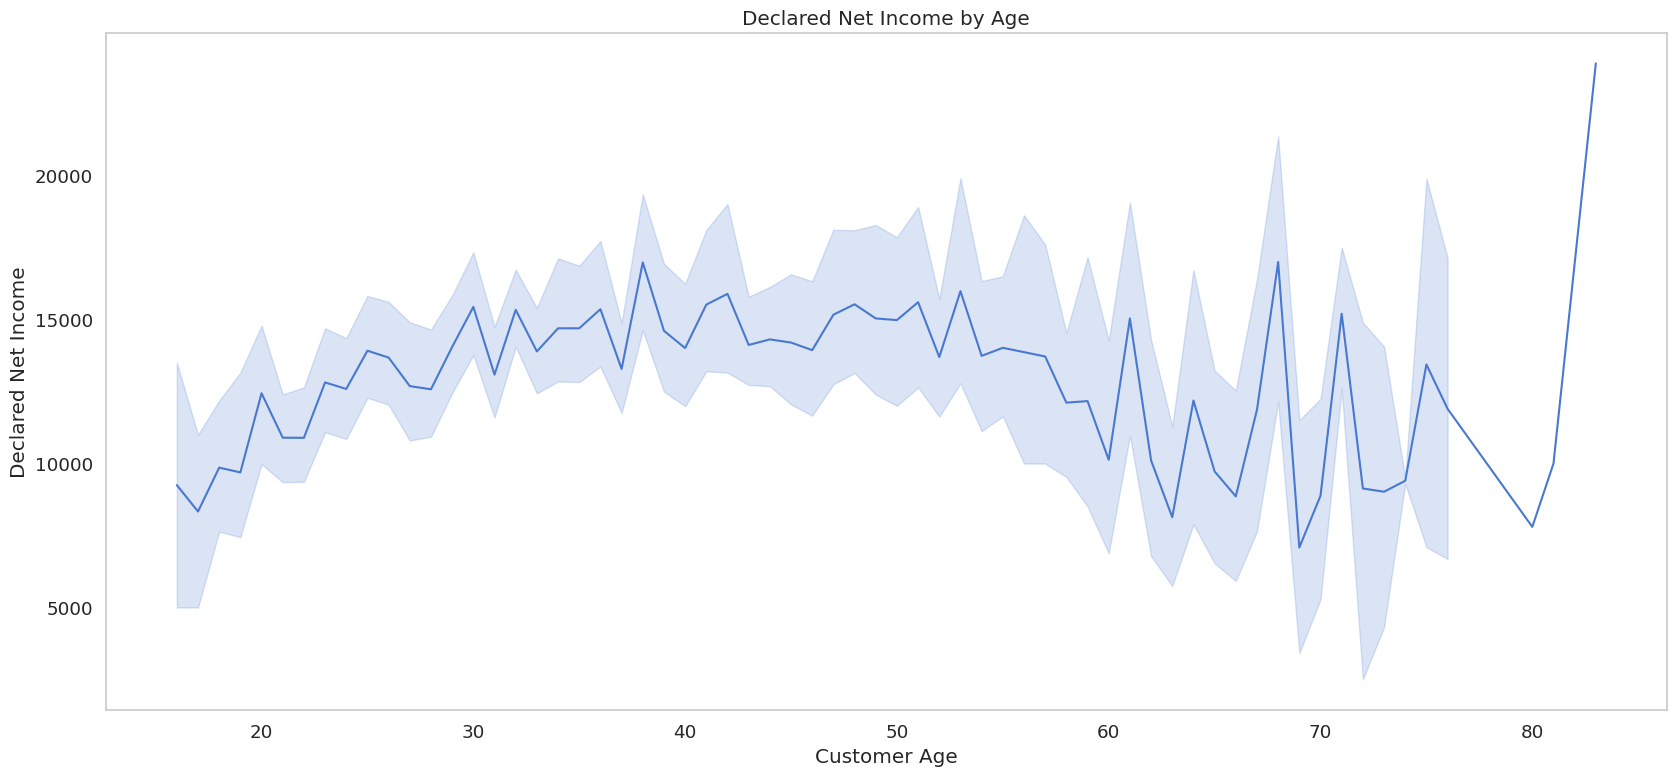

In [34]:
sns.lineplot(data = train_cust_df, x="AGE", y = "DECLARED_NET_INCOME")
plt.title("Declared Net Income by Age")
plt.ylabel("Declared Net Income")
plt.xlabel("Customer Age")
plt.grid()
plt.tight_layout()
plt.show();

The declared net income shows a general increasing trend between the ages of 20 and 30, despite some local fluctuations. Between the ages of 30 and 50, income remains relatively stable, with moderate variability. Around age 50, a gradual decline in declared net income begins, again with localized fluctuations. For customers aged 60 and above, income variability becomes significantly higher, which may be due to a smaller sample size in this age group or indicative of disparities in financial planning and retirement savings among seniors. The sharp spikes and dips in the later years suggest that some individuals maintain high incomes post-retirement, while others experience a more pronounced decline.

### Transations overview

In [35]:
transactions_df =  wr.s3.read_csv(os.path.join(input_s3_path, "transactions.csv"))
transactions_df.info()
transactions_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847544 entries, 0 to 847543
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   TRANSACTION_DESCRIPTION  475339 non-null  object 
 1   CUSTOMER_IDENTIFIER      847544 non-null  object 
 2   RECORD_DATE              847544 non-null  object 
 3   ACCOUNT_TYPE_CODE        847544 non-null  object 
 4   ACCOUNT_BALANCE          847544 non-null  float64
 5   AMT                      847544 non-null  float64
 6   EVENT_NUMBER             847544 non-null  int64  
 7   PRODUCT_CODE             847544 non-null  object 
 8   CHANNEL                  847544 non-null  object 
 9   ACCOUNT_NUMBER           847544 non-null  object 
 10  TRANSACTION_REFERENCE    475339 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 71.1+ MB


,TRANSACTION_DESCRIPTION,CUSTOMER_IDENTIFIER,RECORD_DATE,ACCOUNT_TYPE_CODE,ACCOUNT_BALANCE,AMT,EVENT_NUMBER,PRODUCT_CODE,CHANNEL,ACCOUNT_NUMBER,TRANSACTION_REFERENCE
0,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-13 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,1857.56,1000.00,11785,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
1,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-02-26 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,8843.46,-2000.00,11348,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
2,POS PURCHASE,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-26 00:00:00+02:00,e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...,23.82,-199.98,148,CHEQ,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,04ae923a903fb07b5c846eb61eda25c4766800f02c2e09...
3,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-03-27 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,198.11,-79.39,11419,SAVE,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
4,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-05-06 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,13631.60,-200.00,11528,SAVE,atm,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN


In [36]:
# Cardinality of each column
transactions_df.nunique()

TRANSACTION_DESCRIPTION       128
CUSTOMER_IDENTIFIER          5144
RECORD_DATE                   427
ACCOUNT_TYPE_CODE              19
ACCOUNT_BALANCE            568544
AMT                        109664
EVENT_NUMBER                39220
PRODUCT_CODE                    2
CHANNEL                         4
ACCOUNT_NUMBER               5587
TRANSACTION_REFERENCE      136699
dtype: int64

In [37]:
# columns summary statistics
transactions_df.describe()

,ACCOUNT_BALANCE,AMT,EVENT_NUMBER
count,847544.000000,847544.000000,847544.000000
mean,5267.905511,12.387409,6378.685024
std,6949.438819,3054.419311,7172.905368
min,-2499.970000,-90000.000000,2.000000
25%,693.167500,-400.000000,1398.000000
50%,2591.815000,-120.000000,4026.000000
75%,7065.047500,-29.000000,8925.000000
max,49974.680000,51027.040000,51901.000000


<!-- **Data Profiling Summary**

The dataset contains `847,544` transactions across `11` columns, capturing details of financial transactions such as `account balances`, `transaction amounts`, `channels`, and `product codes`. The memory footprint is approximately `71.1 MB`. It has 8 object columns and 2 float columns and 1 int column.

Upon examining the data, it is evident that while most columns are complete, there are missing values in two key fields: **TRANSACTION_DESCRIPTION** and **TRANSACTION_REFERENCE**, with only 56% non-null entries. This suggests that many transactions either lack descriptions or references, which could impact certain analyses, such as identifying transaction patterns based on descriptions.

The transaction timestamps, stored under **RECORD_DATE**, are in an object format rather than a proper datetime type. Converting this field into a datetime format will be necessary for time-based analysis, such as tracking transaction trends or seasonality.

The monetary fields, **ACCOUNT_BALANCE** and **AMT**, are numeric, but the **AMT** column contains both positive and negative values, indicating credits and debits. The **ACCOUNT_BALANCE** minimum is negative, this might indicate the presence of some overdraft facilicity, although the low value  cast doubt to that theory.

 -->
**1. Distribution of Transaction Amounts (AMT)**
- The `AMT` column has a high standard deviation (\~3,054) compared to the mean (~12.39), suggesting the presence of extreme values.
- The min value (-90,000) and max value (51,027.04) indicate large negative and positive amounts, which could be outliers or special types of transactions (e.g., refunds, bulk deposits, etc.).

**2. Account Balance Trends**
- The `ACCOUNT_BALANCE` has a wide range (min: -2499.97, max: 49,974.68) and a high standard deviation (~6,949).
25% percentile is 693, while the 75% percentile is 7,065, meaning balances are heavily skewed.
  
**3. Missing Data Analysis**
- `TRANSACTION_DESCRIPTION` and `TRANSACTION_REFERENCE` have missing values (~56% non-null), meaning they are not consistently captured.

**4. Event Number Distribution**
- The `EVENT_NUMBER` column is highly skewed (mean: 6,378, max: 51,901), suggesting that some accounts have significantly more transactions.
  
**5. Account Type & Product Code Insights**
- Only 2 unique `PRODUCT_CODE`s and 19 unique `ACCOUNT_TYPE_CODE`s exist.

**6. Record Date Format**
- The transaction timestamps, stored under `RECORD_DATE`, are in an object format rather than a proper datetime type. Converting this field into a datetime format will be necessary for time-based analysis, such as tracking transaction trends or seasonality.


In [38]:
transactions_df['RECORD_DATE'] = pd.to_datetime(transactions_df['RECORD_DATE'])
transactions_df['RECORD_MONTH']  = transactions_df['RECORD_DATE'].dt.to_period('M')

/tmp/ipykernel_9044/1181717438.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions_df['RECORD_MONTH']  = transactions_df['RECORD_DATE'].dt.to_period('M')


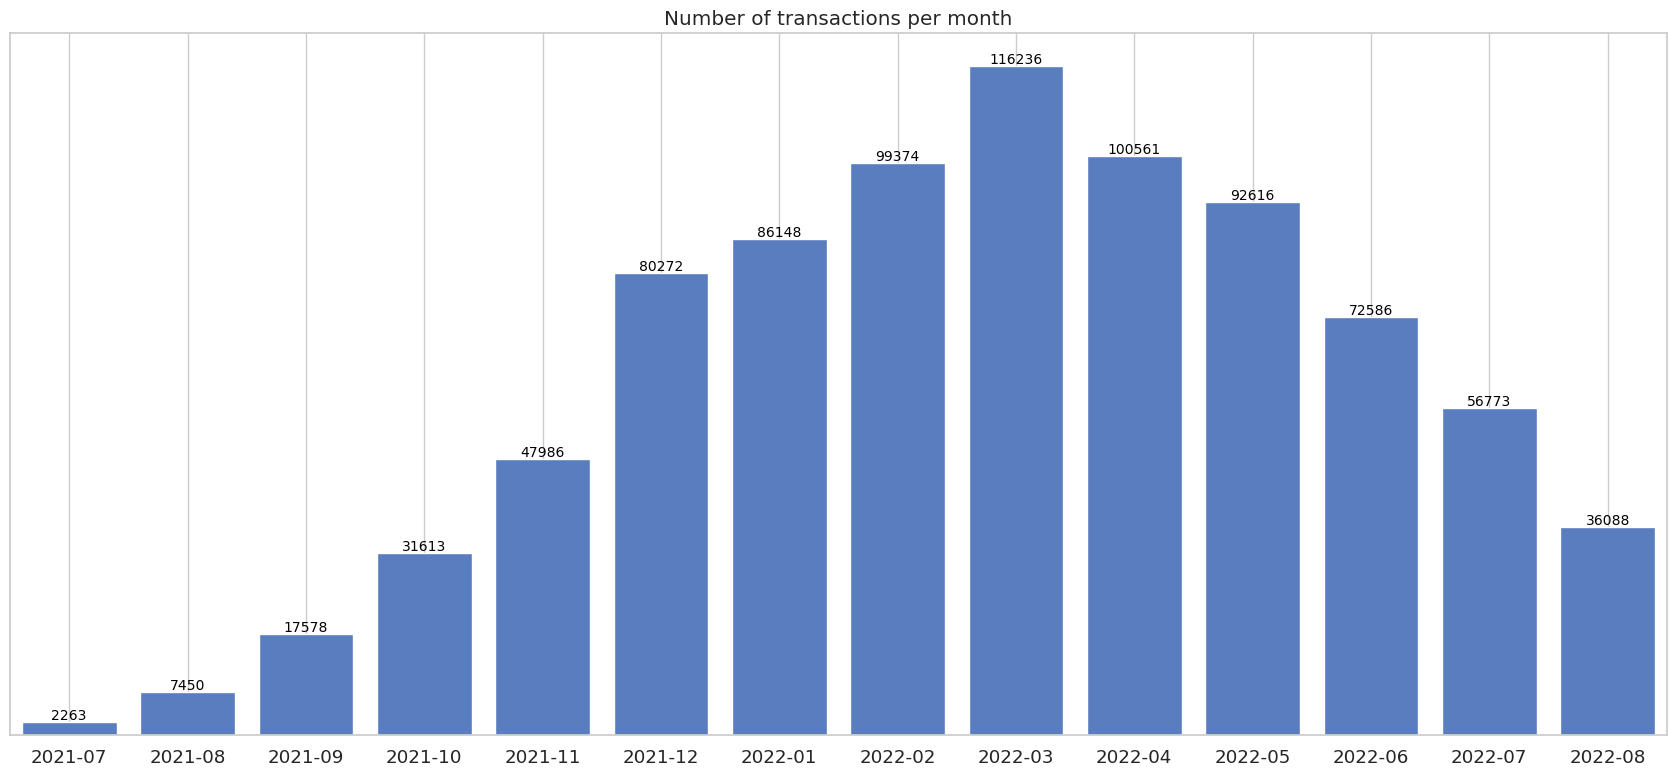

In [313]:
transaction_per_month_counts = transactions_df['RECORD_MONTH'].value_counts().sort_index()
ax = sns.barplot(x=transaction_per_month_counts.index, y=transaction_per_month_counts.values)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Customize the plot
plt.title("Number of transactions per month")
plt.xlabel("")
ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.grid()
plt.show()



The dataset shows 847,544 total transactions recorded over time. The number of monthly transactions increased from 2,263 in July 2021 to a peak of 116,236 in March 2022, followed by a decline to 36,088 in August 2022.

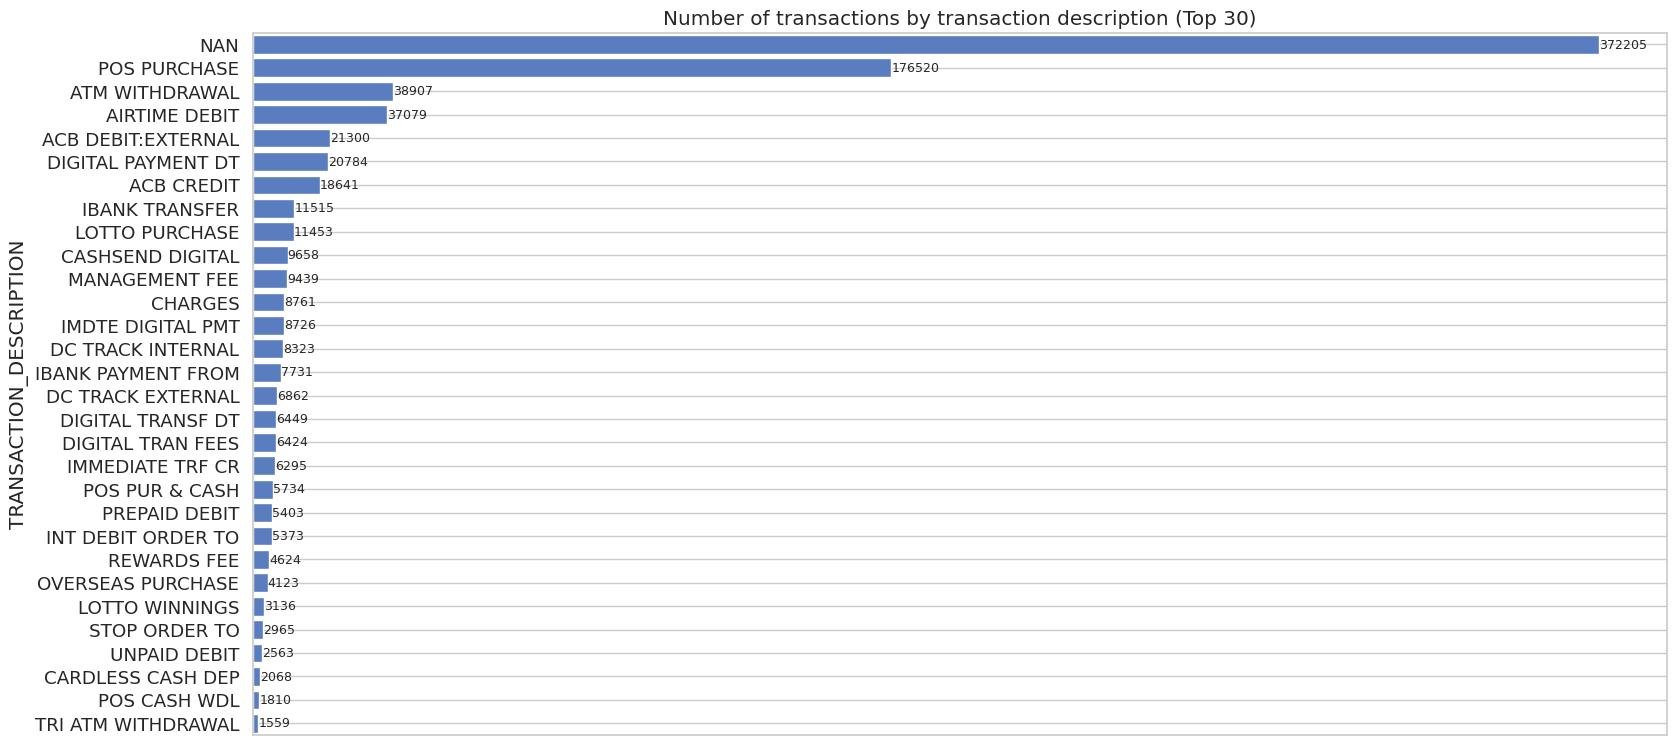

In [74]:
transactions_desc_counts = transactions_df.TRANSACTION_DESCRIPTION.value_counts(dropna=False).sort_values(ascending=False).head(30)
ax = sns.barplot(x=transactions_desc_counts.values.astype(int), y=transactions_desc_counts.index.map(str).str.upper() , orient='h')
ax.bar_label(ax.containers[0], fontsize=9)
plt.title("Number of transactions by transaction description (Top 30)")
plt.grid()
plt.tight_layout()
ax.get_xaxis().set_visible(False)
plt.show();

***Analysis of Top 30 Transaction Types***

**1. Overview of Transaction Types**
- The dataset contains various transaction types, with some occurring significantly more frequently than others. Below is an analysis of the top 30 transaction descriptions based on their frequency.

**2. Missing or Unclassified Transactions**
- The most common transaction type is **NaN (missing values)**, appearing **372,205 times**.
- This suggests that a substantial portion of transactions lack descriptions or are not properly categorized.
- Investigating the source of these missing values can improve data completeness.

**3. Most Frequent Transaction Types**
| **Transaction Type**       | **Count**  | **Description** |
|----------------------------|------------|----------------|
| **POS PURCHASE**          | 176,520     | Customers frequently use point-of-sale (POS) terminals for purchases. |
| **ATM WITHDRAWAL**        | 38,907      | Significant reliance on cash withdrawals despite digital banking trends. |
| **AIRTIME DEBIT**         | 37,079      | High demand for mobile airtime purchases via account debit. |
| **ACB DEBIT: EXTERNAL**   | 21,300      | Regular automatic debits, likely related to external payments. |
| **DIGITAL PAYMENT DT**    | 20,784      | Growing adoption of digital payments. |
| **ACB CREDIT**           | 18,641      | Credits from automated clearing bureau transactions. |
| **IBANK TRANSFER**        | 11,515      | Online banking transfers show a strong digital banking presence. |
| **LOTTO PURCHASE**       | 11,453      | Many customers participate in lottery purchases. |
| **CASHSEND DIGITAL**      | 9,658       | Digital cash transfers gaining traction. |
| **MANAGEMENT FEE**       | 9,439       | Routine bank account management fees. |
| **CHARGES**              | 8,761       | Other general charges on customer accounts. |
| **IMDTE DIGITAL PMT**    | 8,726       | Immediate digital payments processing. |

**4. Digital and External Transactions**
- **ACB DEBIT: EXTERNAL** (**21,300 transactions**) and **ACB CREDIT** (**18,641 transactions**) highlight automated financial transactions.
- **IBANK TRANSFER** (**11,515 transactions**) and **IBANK PAYMENT FROM** (**7,731 transactions**) show a reliance on online banking.
- **DIGITAL TRAN FEES** (**6,424 transactions**) indicate service fees linked to digital transactions.

**5. Fees and Charges**
- **MANAGEMENT FEE** (**9,439 transactions**) and **CHARGES** (**8,761 transactions**) represent account maintenance costs.
- **REWARDS FEE** (**4,624 transactions**) suggests fees related to loyalty programs or premium banking services.

**6. Gambling and Entertainment**
- **LOTTO PURCHASE** (**11,453 transactions**) and **LOTTO WINNINGS** (**3,136 transactions**) suggest a strong engagement with lottery activities.

**7. Miscellaneous Observations**
- **OVERSEAS PURCHASE** (**4,123 transactions**) highlights international spending behavior.
- **STOP ORDER TO** (**2,965 transactions**) and **UNPAID DEBIT** (**2,563 transactions**) indicate recurring payments and potential payment failures.

**8. Conclusion**
- POS purchases, digital payments, and ATM withdrawals dominate customer activity.
- Fees and service charges are common, which may impact customer satisfaction.
- Missing transaction descriptions should be investigated to improve data quality.

In [84]:
transactions_df.PRODUCT_CODE.value_counts(dropna=False)

PRODUCT_CODE
CHEQ    475339
SAVE    372205
Name: count, dtype: int64

We are observing a higher volume of transactions from cheque accounts, accounting for approximately 56%, compared to savings accounts.

In [68]:
transactions_df.CHANNEL.value_counts(dropna=False)

CHANNEL
system      509581
atm         197261
internet    119238
teller       21464
Name: count, dtype: int64

The system channel dominates with the highest number of transactions, reaching over 500,000, followed by the ATM channel with around 197,000 transactions. The internet channel accounts for just over 119,000 transactions, while the teller channel sees the lowest activity, with only around 21,000 transactions. This indicates a preference for digital and automated channels over manual teller interactions.

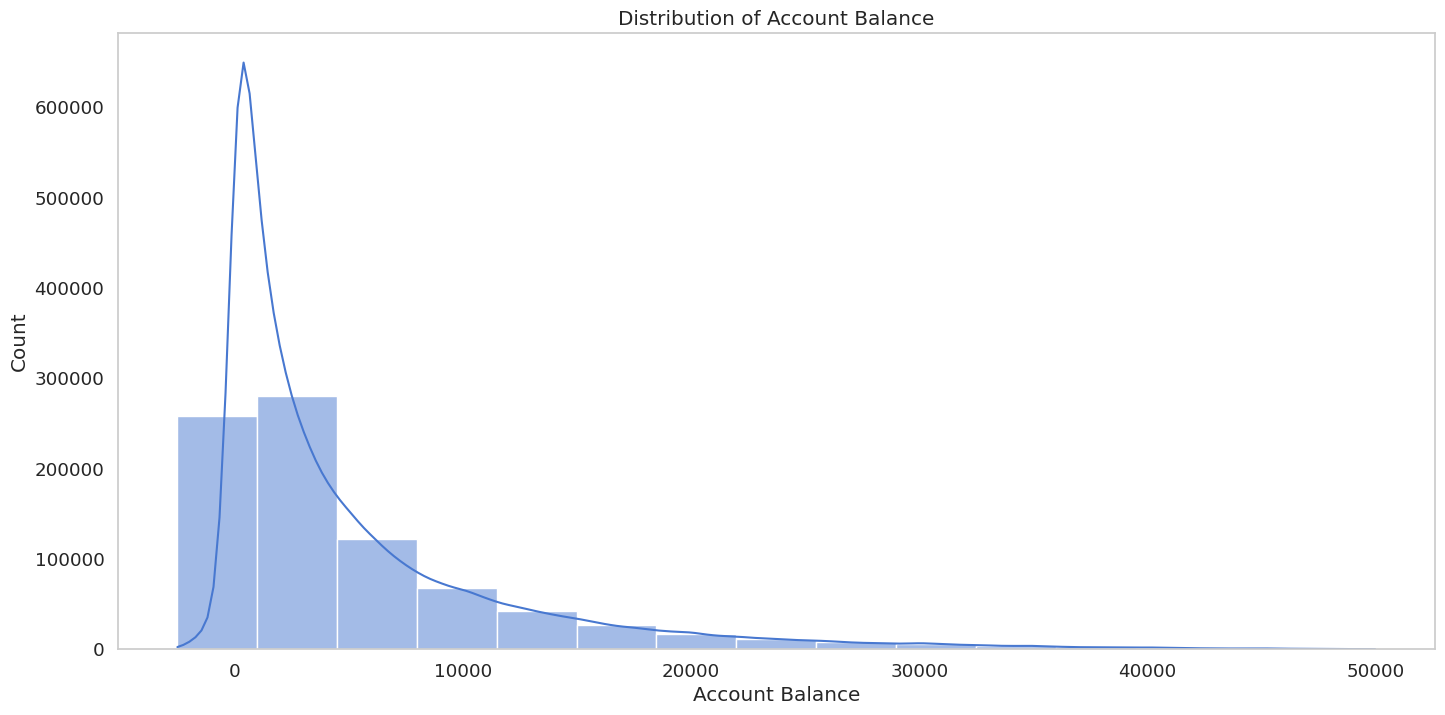

In [85]:
sns.histplot(transactions_df['ACCOUNT_BALANCE'], kde=True, bins=15)
plt.title("Distribution of Account Balance")
plt.xlabel("Account Balance")
plt.grid()
plt.show()

The account balance distribution exhibits a significant right skew, meaning that most transactions are associated with lower account balances. However, there are fewer transactions at the higher end of the balance spectrum, which disproportionately raises the average balance per transaction. This suggests that while the majority of transactions involve smaller balances, the few high-balance transactions have a strong impact on the overall average.

### Transactions feature engineering

The code below creates several helper columns in the transactions_df DataFrame to categorize and segment transaction data, such as identifying cheque and savings transactions, separating inbound and outbound amounts, flagging different transaction channels (system, ATM, internet, teller), and tagging specific transaction types (POS purchases, ATM withdrawals, airtime debits). These helper columns enable more efficient aggregations and analysis by allowing easy grouping and summarization of data based on product, channel, transaction type, and account balance.

In [86]:
# creating helper columns
transactions_df["IS_CHEQ_TRANS"] = np.where(transactions_df.PRODUCT_CODE == "CHEQ", 1, 0)
transactions_df["IS_SAVE_TRANS"] = np.where(transactions_df.PRODUCT_CODE == "SAVE", 1, 0)
transactions_df["CHEQ_AMT"] = transactions_df.loc[transactions_df.PRODUCT_CODE == "CHEQ", "AMT"]
transactions_df["SAVE_AMT"] = transactions_df.loc[transactions_df.PRODUCT_CODE == "SAVE", "AMT"]
transactions_df["INBOUND_AMT"] = transactions_df.loc[transactions_df.AMT>0, "AMT"]
transactions_df["OUTBOUND_AMT"] = transactions_df.loc[transactions_df.AMT<0, "AMT"]
transactions_df["CHEQ_INBOUND_AMT"] = transactions_df.loc[(transactions_df.PRODUCT_CODE == "CHEQ") & (transactions_df.AMT>0), "AMT"]
transactions_df["SAVE_INBOUND_AMT"] = transactions_df.loc[(transactions_df.PRODUCT_CODE == "SAVE") & (transactions_df.AMT>0), "AMT"]
transactions_df["CHEQ_OUTBOUND_AMT"] = np.abs(transactions_df.loc[(transactions_df.PRODUCT_CODE == "CHEQ") & (transactions_df.AMT<0), "AMT"])
transactions_df["SAVE_OUTBOUND_AMT"] = np.abs(transactions_df.loc[(transactions_df.PRODUCT_CODE == "SAVE") & (transactions_df.AMT<0), "AMT"])

transactions_df["IS_SYSTEM_CHANNEL"] = np.where(transactions_df.CHANNEL == "system", 1, 0)
transactions_df["IS_ATM_CHANNEL"] = np.where(transactions_df.CHANNEL == "atm", 1, 0)
transactions_df["IS_INTERNET_CHANNEL"] = np.where(transactions_df.CHANNEL == "internet", 1, 0)
transactions_df["IS_TELLER_CHANNEL"] = np.where(transactions_df.CHANNEL == "teller", 1, 0)

transactions_df["CHEQ_ACCOUNT_BALANCE"] = transactions_df.loc[transactions_df.PRODUCT_CODE == "CHEQ", "ACCOUNT_BALANCE"]
transactions_df["SAVE_ACCOUNT_BALANCE"] = transactions_df.loc[transactions_df.PRODUCT_CODE == "SAVE", "ACCOUNT_BALANCE"]

transactions_df["IS_POS_TRANS"] =np.where(transactions_df.TRANSACTION_DESCRIPTION == "POS PURCHASE",1,0)
transactions_df["IS_ATM_WITHDRAW_TRANS"] =np.where(transactions_df.TRANSACTION_DESCRIPTION == "ATM WITHDRAWAL",1,0)
transactions_df["IS_AIRTIME_DEBIT_TRANS"] =np.where(transactions_df.TRANSACTION_DESCRIPTION == "AIRTIME DEBIT",1,0)


We aggregated the transaction data by customer and month, producing key statistics such as transaction counts, account balances, and inbound/outbound amounts. It calculates averages, maxima, minima, medians, standard deviations, and percentiles for account balances and amounts. Additionally, it tracks transactions by product type (cheque, savings) and transaction channel (system, ATM, internet, teller), as well as specific transaction types (POS, ATM withdrawals, airtime debits). These monthly aggregations are crucial for predicting monthly declared income, as they provide insights into customer behavior and financial activity, helping to build more accurate predictive models and inform income estimation processes.

In [87]:
trans_per_cust_per_month_df = (
    transactions_df
    .groupby(["CUSTOMER_IDENTIFIER", "RECORD_MONTH"])
    .agg(CNT_TRNS = ("EVENT_NUMBER", "count"),
         AVG_ACC_BAL = ("ACCOUNT_BALANCE", "mean"),
         MAX_ACC_BAL =  ("ACCOUNT_BALANCE", "max"),
         MIN_ACC_BAL =  ("ACCOUNT_BALANCE", "min"),
         MEDIAN_ACC_BAL =  ("ACCOUNT_BALANCE", "median"),
         STDDEV_ACC_BAL =  ("ACCOUNT_BALANCE", "std"),
         NINETIENT_ACC_BAL = ('ACCOUNT_BALANCE', lambda x: x.quantile(0.9)),
         AVG_INBOUND_AMT = ("INBOUND_AMT", "mean"),
         MAX_INBOUND_AMT =  ("INBOUND_AMT", "max"),
         MIN_INBOUND_AMT =  ("INBOUND_AMT", "min"),
         MEDIAN_INBOUND_AMT =  ("INBOUND_AMT", "median"),
         STDDEV_INBOUND_AMT =  ("INBOUND_AMT", "std"),
         NINETIENT_INBOUND_AMT = ("INBOUND_AMT", lambda x: x.quantile(0.9)),
         TOTAL_INBOUND_AMT = ("INBOUND_AMT", "sum"),
         AVG_OUTBOUND_AMT = ("OUTBOUND_AMT", "mean"),
         MAX_OUTBOUND_AMT =  ("OUTBOUND_AMT", "max"),
         MIN_OUTBOUND_AMT =  ("OUTBOUND_AMT", "min"),
         MEDIAN_OUTBOUND_AMT =  ("OUTBOUND_AMT", "median"),
         STDDEV_OUTBOUND_AMT =  ("OUTBOUND_AMT", "std"),
         NINETIENT_OUTBOUND_AMT = ("OUTBOUND_AMT", lambda x: x.quantile(0.9)),
         TOTAL_OUTBOUND_AMT = ("OUTBOUND_AMT", "sum"),
         CNT_CHEQ_TRANS = ("IS_CHEQ_TRANS", "sum"),
         CNT_SAVE_TRANS = ("IS_SAVE_TRANS", "sum"),
         CHEQ_INBOUND_AMT  = ("CHEQ_INBOUND_AMT", "sum"),
         SAVE_INBOUND_AMT  = ("SAVE_INBOUND_AMT", "sum"),
         CHEQ_OUTBOUND_AMT  = ("CHEQ_OUTBOUND_AMT", "sum"),
         SAVE_OUTBOUND_AMT  = ("SAVE_OUTBOUND_AMT", "sum"),
         CNT_SYS_TRNS = ("IS_SYSTEM_CHANNEL", "sum"),
         CNT_ATM_TRNS = ("IS_ATM_CHANNEL", "sum"),
         CNT_INTERNET_TRNS  = ("IS_INTERNET_CHANNEL", "sum"),
         CNT_TELLER_TRNS = ("IS_TELLER_CHANNEL", "sum"),
         AVG_CHEQ_ACC_BAL  = ("CHEQ_ACCOUNT_BALANCE", "mean"),
         AVG_SAVE_ACC_BAL  = ("SAVE_ACCOUNT_BALANCE", "mean"),
         MAX_CHEQ_ACC_BAL  = ("CHEQ_ACCOUNT_BALANCE", "max"),
         MAX_SAVE_ACC_BAL  = ("SAVE_ACCOUNT_BALANCE", "max"),
         MEDIAN_CHEQ_ACC_BAL  = ("CHEQ_ACCOUNT_BALANCE", "median"),
         MEDIAN_SAVE_ACC_BAL  = ("SAVE_ACCOUNT_BALANCE", "median"),
         CNT_POS_TRNS  = ("IS_POS_TRANS", "sum"),
         CNT_ATM_WITHDRAW_TRNS  = ("IS_ATM_WITHDRAW_TRANS", "sum"),
         CNT_AIRTIME_DEBIT_TRNS  = ("IS_AIRTIME_DEBIT_TRANS", "sum"),
         
        )
).reset_index()

We then further aggregated the monthly data to the customer level by taking summary statistics for each month and deriving additional summary statistics at the customer level.

In [89]:
agg_funcs = ['mean', 'min', 'max', 'median', 'std', lambda x: x.quantile(0.75)]

# Perform the groupby operation
flat_trans_df = (
    trans_per_cust_per_month_df
    .groupby('CUSTOMER_IDENTIFIER')
    [trans_per_cust_per_month_df.columns[2:]]
    .agg(agg_funcs)
)

# Rename the last column (75th percentile)
flat_trans_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in flat_trans_df.columns]
flat_trans_df = flat_trans_df.rename(
    columns={col: col.replace('<lambda_0>', '75th_Percentile') for col in flat_trans_df.columns}
).reset_index()

In [90]:
flat_trans_df.head()

,CUSTOMER_IDENTIFIER,CNT_TRNS_mean,CNT_TRNS_min,CNT_TRNS_max,CNT_TRNS_median,CNT_TRNS_std,CNT_TRNS_75th_Percentile,AVG_ACC_BAL_mean,AVG_ACC_BAL_min,AVG_ACC_BAL_max,...,CNT_ATM_WITHDRAW_TRNS_max,CNT_ATM_WITHDRAW_TRNS_median,CNT_ATM_WITHDRAW_TRNS_std,CNT_ATM_WITHDRAW_TRNS_75th_Percentile,CNT_AIRTIME_DEBIT_TRNS_mean,CNT_AIRTIME_DEBIT_TRNS_min,CNT_AIRTIME_DEBIT_TRNS_max,CNT_AIRTIME_DEBIT_TRNS_median,CNT_AIRTIME_DEBIT_TRNS_std,CNT_AIRTIME_DEBIT_TRNS_75th_Percentile
0,ID_000e300f38e067ac4f06255d4ff31010c3b3c6490f1...,57.000000,46,67,61.0,7.979139,61.5,4770.434446,3678.732951,5777.968689,...,6,2.0,1.812654,3.0,11.0,6,17,10.0,3.829708,13.5
1,ID_000fb7f238953e9adc91e3b15584dca6d7004d6ba4a...,17.285714,14,24,16.0,3.592320,18.5,4381.293318,2123.838125,11158.452353,...,2,0.0,0.755929,0.0,0.0,0,0,0.0,0.000000,0.0
2,ID_001d82dc1e7387cd0d9ba634af27d79070d6f483167...,26.571429,8,40,28.0,9.761440,30.5,5046.801995,297.777500,12568.030313,...,7,5.0,1.069045,5.5,0.0,0,0,0.0,0.000000,0.0
3,ID_001e0135a8c795bcacf30315d447cfdb20bcdc170c6...,3.000000,3,3,3.0,NaN,3.0,6764.383333,6764.383333,6764.383333,...,0,0.0,NaN,0.0,0.0,0,0,0.0,NaN,0.0
4,ID_00306a10bf82ce30b11abb32b94a08aebac968ff13a...,37.000000,22,56,33.0,14.000000,48.0,14375.416522,10835.198182,19065.359444,...,0,0.0,0.000000,0.0,0.0,0,0,0.0,0.000000,0.0


In [103]:
# fill missing values with zero
flat_trans_df = flat_trans_df.fillna(0)

### Correlation Analysis

The purpose of this step is to address multicollinearity by removing highly correlated features. We use the Pearson correlation coefficient to measure the strength of the linear relationship between pairs of numerical variables. This coefficient ranges from -1 to 1, with values of 1 and -1 indicating a perfect positive or negative linear relationship, respectively, while values closer to 0 suggest a weak linear relationship. In cases where two features have a correlation greater than 0.9, one of the features (the second one) is removed to reduce multicollinearity. High multicollinearity can distort the results of predictive models by inflating standard errors and making it difficult to determine the individual effect of each feature, so this step helps to ensure a more stable and interpretable model.

In [92]:
corr_matrix = flat_trans_df.iloc[:, 1:].corr().abs()  # Use absolute values to check strength of correlation

# Define the correlation threshold (e.g., 0.9)
threshold = 0.9

# Identify highly correlated features
to_drop = set()  # Set to store columns to drop
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):  # Avoid diagonal and duplicate pairs
        if corr_matrix.iloc[i, j] > threshold:
            colname = corr_matrix.columns[j]  # Select the second variable in the pair
            to_drop.add(colname)

# Drop the highly correlated columns
flat_trans_df_cleaned = flat_trans_df.drop(columns=to_drop)

print(f"Removed {len(to_drop)} highly correlated columns: {to_drop}")


Removed 161 highly correlated columns: {'TOTAL_OUTBOUND_AMT_min', 'CNT_SYS_TRNS_75th_Percentile', 'CNT_ATM_TRNS_median', 'TOTAL_OUTBOUND_AMT_std', 'CNT_SAVE_TRANS_75th_Percentile', 'MEDIAN_ACC_BAL_median', 'MEDIAN_CHEQ_ACC_BAL_mean', 'MEDIAN_CHEQ_ACC_BAL_median', 'NINETIENT_INBOUND_AMT_75th_Percentile', 'AVG_CHEQ_ACC_BAL_max', 'MEDIAN_SAVE_ACC_BAL_median', 'CNT_AIRTIME_DEBIT_TRNS_max', 'MEDIAN_INBOUND_AMT_min', 'AVG_SAVE_ACC_BAL_median', 'CNT_CHEQ_TRANS_median', 'CNT_POS_TRNS_mean', 'CNT_ATM_WITHDRAW_TRNS_median', 'MEDIAN_CHEQ_ACC_BAL_min', 'MEDIAN_OUTBOUND_AMT_min', 'CHEQ_OUTBOUND_AMT_std', 'CNT_SYS_TRNS_median', 'NINETIENT_INBOUND_AMT_max', 'MAX_ACC_BAL_median', 'MEDIAN_INBOUND_AMT_mean', 'MAX_INBOUND_AMT_std', 'MEDIAN_INBOUND_AMT_std', 'MIN_INBOUND_AMT_median', 'AVG_OUTBOUND_AMT_median', 'MEDIAN_INBOUND_AMT_75th_Percentile', 'SAVE_INBOUND_AMT_median', 'CNT_SAVE_TRANS_std', 'CNT_CHEQ_TRANS_min', 'MAX_INBOUND_AMT_mean', 'CNT_INTERNET_TRNS_min', 'CNT_SYS_TRNS_std', 'MAX_INBOUND_AMT_75t

In [93]:
flat_trans_df_cleaned.head()

,CUSTOMER_IDENTIFIER,CNT_TRNS_mean,CNT_TRNS_std,AVG_ACC_BAL_mean,AVG_ACC_BAL_max,AVG_ACC_BAL_std,MAX_ACC_BAL_mean,MAX_ACC_BAL_max,MAX_ACC_BAL_std,MIN_ACC_BAL_mean,...,MAX_SAVE_ACC_BAL_mean,MAX_SAVE_ACC_BAL_min,MAX_SAVE_ACC_BAL_std,CNT_POS_TRNS_min,CNT_ATM_WITHDRAW_TRNS_mean,CNT_ATM_WITHDRAW_TRNS_min,CNT_ATM_WITHDRAW_TRNS_max,CNT_ATM_WITHDRAW_TRNS_std,CNT_AIRTIME_DEBIT_TRNS_mean,CNT_AIRTIME_DEBIT_TRNS_min
0,ID_000e300f38e067ac4f06255d4ff31010c3b3c6490f1...,57.000000,7.979139,4770.434446,5777.968689,663.933160,15720.585714,16775.18,667.252548,23.728571,...,0.000000,0.00,0.000000,10,2.428571,1,6,1.812654,11.0,6
1,ID_000fb7f238953e9adc91e3b15584dca6d7004d6ba4a...,17.285714,3.592320,4381.293318,11158.452353,3203.609906,14741.888571,30703.34,9480.774192,107.207143,...,14741.888571,8788.19,9480.774192,0,0.285714,0,2,0.755929,0.0,0
2,ID_001d82dc1e7387cd0d9ba634af27d79070d6f483167...,26.571429,9.761440,5046.801995,12568.030313,4002.769064,19721.704286,46859.91,14816.072360,8.188571,...,0.000000,0.00,0.000000,2,5.142857,4,7,1.069045,0.0,0
3,ID_001e0135a8c795bcacf30315d447cfdb20bcdc170c6...,3.000000,0.000000,6764.383333,6764.383333,0.000000,14243.150000,14243.15,0.000000,50.000000,...,14243.150000,14243.15,0.000000,0,0.000000,0,0,0.000000,0.0,0
4,ID_00306a10bf82ce30b11abb32b94a08aebac968ff13a...,37.000000,14.000000,14375.416522,19065.359444,3158.965468,30207.595714,43348.43,6447.779442,1577.874286,...,30207.595714,25166.64,6447.779442,0,0.000000,0,0,0.000000,0.0,0


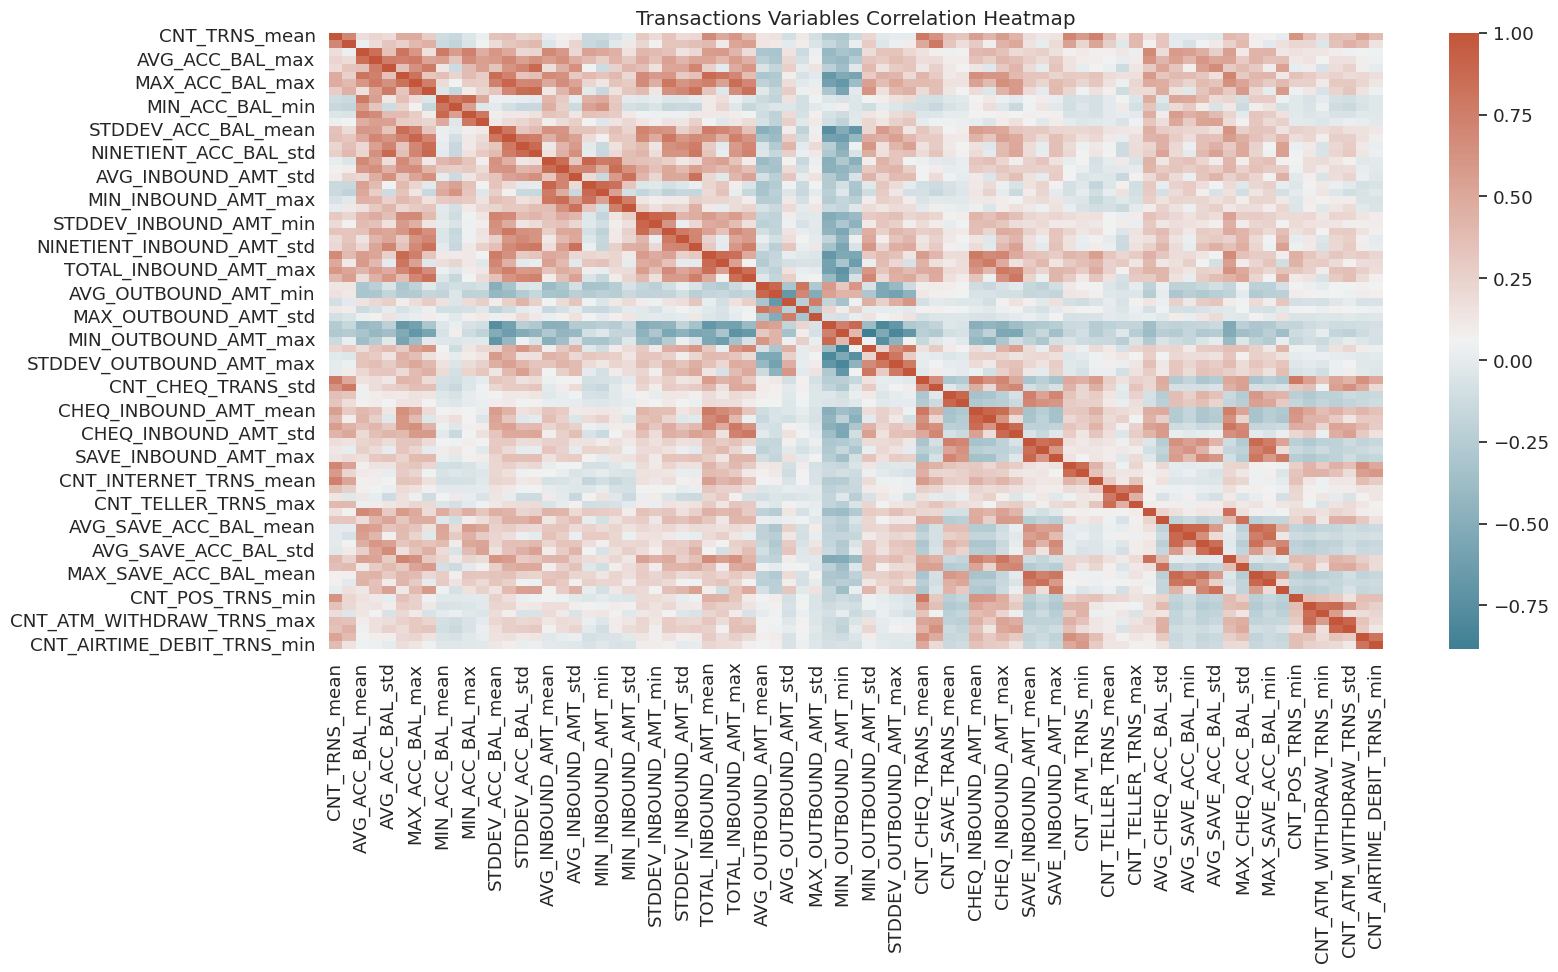

In [94]:
sns.heatmap(flat_trans_df_cleaned.iloc[:, 1:].corr(), cmap= sns.diverging_palette(220, 20, as_cmap=True))
plt.title("Transactions Variables Correlation Heatmap");

#### Preparing Training Set

The process begins by merging the training customer dataset (train_cust_df) with the cleaned transaction data (flat_trans_df_cleaned) on the CUSTOMER_IDENTIFIER. The resulting DataFrame (train_df) sets CUSTOMER_IDENTIFIER, RECORD_DATE, and DATE_LAST_UPDATED as the index. The target variable y is defined as the "DECLARED_NET_INCOME," while the feature matrix X includes all columns except the first one.

Next, the data is split into training, validation, and test sets. The training set (X_train, y_train) is separated from the test set (X_test, y_test) with 90% of the data used for training. The training set is further divided into a training and validation set, with 85% of the training data used for training and the remaining 15% for validation. The random seed is fixed at 100 for reproducibility.

In [95]:
# merge train set with flatted_transaction table
train_df = train_cust_df.merge(flat_trans_df_cleaned, on="CUSTOMER_IDENTIFIER")
# set customer identifiers to index
train_df.set_index(["CUSTOMER_IDENTIFIER",	"RECORD_DATE", "DATE_LAST_UPDATED"], inplace=True)
y = train_df["DECLARED_NET_INCOME"]
X = train_df.iloc[:,1:]

# train, validation and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, random_state=100)

Standardizing data is a crucial step for many machine learning algorithms, particularly those that rely on distance metrics or gradient-based optimization, such as Logistic Regression. Standardization ensures that all features have a similar scale, preventing features with larger scales from disproportionately influencing the model. It helps in achieving:

- **Equal Feature Contribution**: Ensures that each feature contributes equally to the model’s predictions.
- **Improved Gradient Descent Convergence**: Helps gradient descent algorithms converge faster by preventing issues related to differing feature scales.
- **Algorithm Assumptions**: Many algorithms assume that features are centered around zero with a similar scale, which is achieved through standardization.
- **Enhanced Interpretability**: Standardization allows better comparison between feature coefficients, making the model’s results easier to interpret.

However, for tree-based algorithms (such as Decision Trees, Random Forests, and Gradient Boosting Machines), standardization is unnecessary. Tree-based models work by splitting data based on feature values, and they are invariant to scale. Since they don't rely on mathematical operations that are sensitive to feature scales, standardizing features doesn’t affect their performance. These models also excel in capturing non-linear relationships and can handle mixed data types (numerical and categorical) without requiring transformation, making standardization redundant.











In [96]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_val_std =  sc.transform(X_val)
X_test_std =  sc.transform(X_test)

### Train Baseline Models

The evaluation metric is the root mean squared error. The code below compares several models using cross validation with 5 folds.

In [102]:
list_of_results = []

for algorithm in [LinearRegression(),
                  Ridge(random_state=100),
                  Lasso(random_state=100),
                  SVR(kernel='linear'),
                  DecisionTreeRegressor(random_state=100),
                  RandomForestRegressor(random_state=100),
                  XGBRegressor(objective="reg:gamma", random_state=100),
                  LGBMRegressor(random_state=100),
                  AdaBoostRegressor(random_state=100)]:
    results = abs(cross_val_score(algorithm,
                                  X_train_std, 
                                  y_train,
                                  scoring='neg_root_mean_squared_error',
                                  cv=5, 
                                  verbose=False))
    
    result_dict = {'algorithm' : str(algorithm)[:str(algorithm).index('(')],
                   'rmse_mean' : np.mean(results), 
                   'rmse_median' : np.median(results),
                   'rmse_min' : np.min(results), 
                   'rmse_max' : np.max(results),
                   'std' : np.std(results)}
    list_of_results.append(result_dict)
df_results = pd.DataFrame(list_of_results).set_index('algorithm')

index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'font-style: italic; color: black; font-weight:normal'
}
cmap = sns.color_palette("crest", as_cmap=True)
(
    df_results
    .sort_values(by="rmse_mean")
    .style
    .format('{:.2f}')
    .set_table_styles([index_names, headers])
    .background_gradient(axis=0, cmap=sns.diverging_palette(220, 20, as_cmap=True))
)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.221e+09, tolerance: 2.369e+07
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.823e+09, tolerance: 2.331e+07
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.156e+09, tolerance: 2.475e

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17680
[LightGBM] [Info] Number of data points in the train set: 2203, number of used features: 84
[LightGBM] [Info] Start training from score 14104.584657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17678
[LightGBM] [Info] Number of data points in the train set: 2203, number of used features: 84
[LightGBM] [Info] Start training from score 13930.867000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17666
[LightGBM] [Info] Number of data points in the 

,rmse_mean,rmse_median,rmse_min,rmse_max,std
algorithm,,,,,
RandomForestRegressor,6130.65,5726.93,5649.97,7094.36,568.65
LGBMRegressor,6141.88,5933.35,5673.40,7187.43,534.46
XGBRegressor,6327.80,6006.62,5564.43,7646.77,720.48
Lasso,7951.01,8160.96,7295.82,8369.64,425.35
Ridge,7953.16,8161.98,7302.29,8371.11,422.24
LinearRegression,8016.43,8165.75,7321.87,8536.87,442.54
DecisionTreeRegressor,8418.64,7953.56,7806.88,10016.86,828.96
AdaBoostRegressor,8549.14,8336.38,7938.26,9276.94,470.00
SVR,9821.44,9976.63,8824.43,10348.41,519.00


**Key Insights:**
- RandomForestRegressor and LGBMRegressor provide the lowest RMSE values, indicating strong performance in predicting the target variable with relatively low error.
- XGBRegressor also performs well, but its RMSE values are slightly higher compared to RandomForestRegressor and LGBMRegressor.
- Models like Lasso, Ridge, and LinearRegression show higher RMSE values, suggesting they may not perform as well as the tree-based models for this particular dataset.
- DecisionTreeRegressor, AdaBoostRegressor, and SVR have higher RMSE values, indicating they might be less suitable or require further tuning for this task.

These results indicate that tree-based models like RandomForestRegressor and LGBMRegressor are the most accurate for this problem, based on the RMSE metric.

#### Examine Top 3 Models

In [104]:
rf = RandomForestRegressor(random_state=100)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
print(f"The root mean squared error is : {root_mean_squared_error(y_val, y_pred_rf)}")
print(f"The r2 is : {r2_score(y_val, y_pred_rf)}")

The root mean squared error is : 6361.811944410914
The r2 is : 0.532619143878785


In [105]:
lgm = LGBMRegressor(random_state=45)
lgm.fit(X_train, y_train)

y_pred_lg = lgm.predict(X_val)
print(f"The root mean squared error is : {root_mean_squared_error(y_val, y_pred_lg)}")
print(f"The r2 is : {r2_score(y_val, y_pred_lg)}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17844
[LightGBM] [Info] Number of data points in the train set: 2754, number of used features: 84
[LightGBM] [Info] Start training from score 14084.422658
The root mean squared error is : 6587.298533559833
The r2 is : 0.4989005140328012


In [106]:
xgb = XGBRegressor(objective="reg:gamma", random_state=100)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)
print(f"The root mean squared error is : {root_mean_squared_error(y_val, y_pred_xgb)}")
print(f"The r2 is : {r2_score(y_val, y_pred_xgb)}")

The root mean squared error is : 6510.548224363926
The r2 is : 0.5105093717575073


Random Forest continues to outperform all other algorithms with an RMSE of 6361.81 and an R-squared value of 0.54. The R-squared value indicates that 54% of the variation in the data can be explained by the model, suggesting that the model does a reasonably good job of capturing the underlying patterns in the data. While there is still room for improvement, the Random Forest model remains the most effective among the evaluated algorithms

#### Recursive Feature Elimination Steps 

**RandomForestRegressor**: A Random Forest model for regression is initialized with a fixed random seed (random_state=345), ensuring reproducibility.

**RFECV (Recursive Feature Elimination with Cross-Validation)**: 
- This technique is used to select the best features by recursively removing the least important ones.
- The model (rf) is used within this process to evaluate feature importance.
-  It performs feature selection using cross-validation with 5 folds (cv=5).
-  The scoring metric used is negative root mean squared error (scoring="neg_root_mean_squared_error"), which helps assess model performance during feature elimination.

**Fit the Selector**: The fit() function is called on the selector object to apply the RFECV feature selection process on the training data (X_train, y_train). The result of this process will determine which features are the most important for the regression task.



In [107]:
rf = RandomForestRegressor(random_state=345)
selector = RFECV(rf, step=1, cv=5, scoring="neg_root_mean_squared_error")
selector = selector.fit(X_train, y_train)

In [108]:
print(f"Optimal number of features: {selector.n_features_}")

Optimal number of features: 27


RFE with cross validation is quite an expensive process, so we proceeding to save the columns name on disk for future purposes.

In [109]:
joblib.dump(X.loc[:, selector.support_].columns, f"artifacts/rfe_support-{datetime.strftime(datetime.now(), '%Y-%m-%d-%H-%M')}.joblib")

['artifacts/rfe_support-2025-01-19-13-56.joblib']

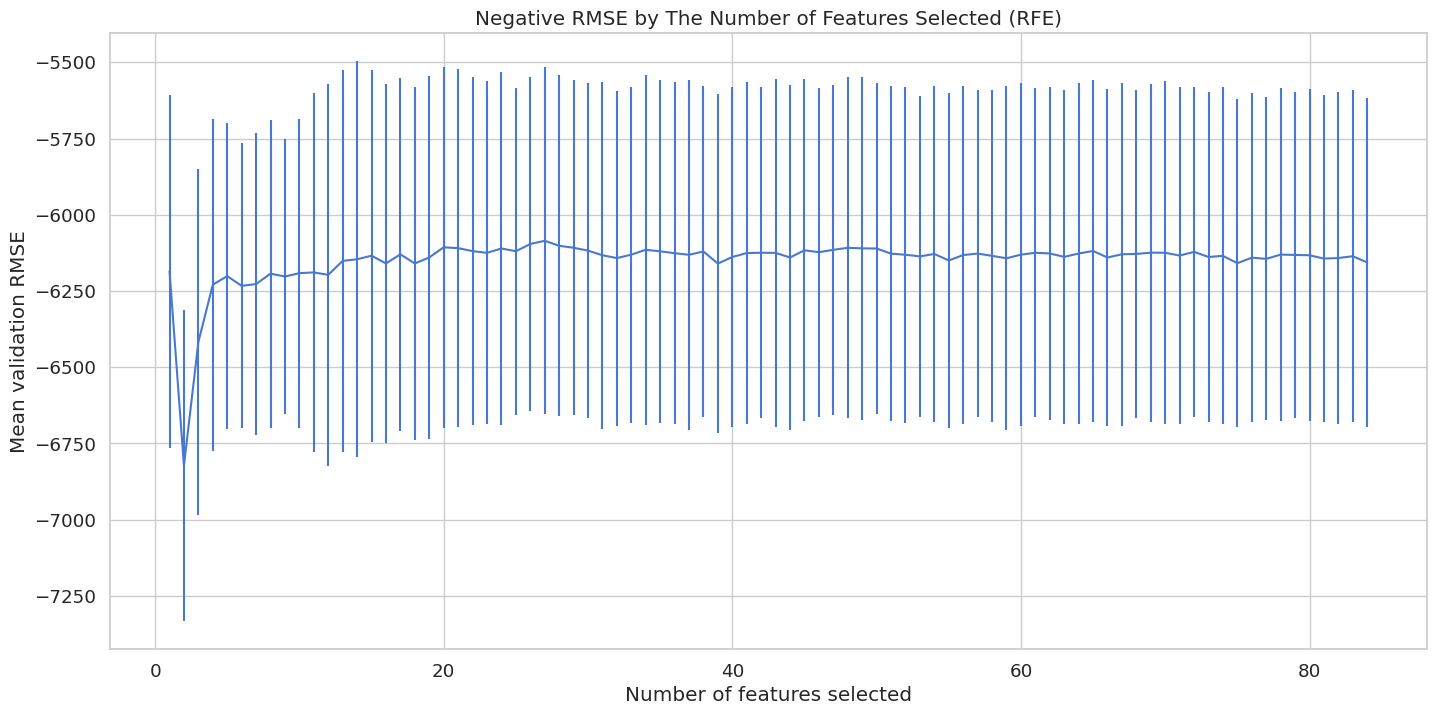

In [110]:
cv_results = pd.DataFrame(selector.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean validation RMSE")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Negative RMSE by The Number of Features Selected (RFE)")
plt.show()

#### Fit & Compare Reduced Models
In this section we fit repeating the modelling process using variables that remain after RFE.

In [111]:
X_reduced = X.loc[:, selector.support_]

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, train_size=0.9, random_state=100)

X_train_reduced, X_val_reduced, y_train_reduced, y_val_reduced = train_test_split(X_train_reduced, y_train_reduced, train_size=0.85, random_state=100)

In [112]:
sc = StandardScaler()
X_train_reduced_std = sc.fit_transform(X_train_reduced)
X_val_reduced_std =  sc.transform(X_val_reduced)
X_test_reduced_std =  sc.transform(X_test_reduced)

In [113]:
list_of_results = []

for algorithm in [LinearRegression(),
                  Ridge(),
                  Lasso(),
                  SVR(),
                  DecisionTreeRegressor(),
                  RandomForestRegressor(),
                  XGBRegressor(objective="reg:gamma"),
                  LGBMRegressor(),
                  AdaBoostRegressor()]:
    results = abs(cross_val_score(algorithm,
                                  X_train_reduced_std, 
                                  y_train_reduced,
                                  scoring='neg_root_mean_squared_error',
                                  cv=5,
                                  verbose=False))
    
    result_dict = {'algorithm' : str(algorithm)[:str(algorithm).index('(')],
                   'rmse_mean' : np.mean(results), 
                   'rmse_median' : np.median(results),
                   'rmse_min' : np.min(results), 
                   'rmse_max' : np.max(results),
                   'std' : np.std(results)}
    list_of_results.append(result_dict)
df_results = pd.DataFrame(list_of_results).set_index('algorithm')

index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'font-style: italic; color: black; font-weight:normal'
}
(
    df_results
    .sort_values(by="rmse_mean")
    .style
    .format('{:.2f}')
    .set_table_styles([index_names, headers])
    .background_gradient(axis=0, cmap=sns.diverging_palette(220, 20, as_cmap=True))
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6025
[LightGBM] [Info] Number of data points in the train set: 2203, number of used features: 27
[LightGBM] [Info] Start training from score 14104.584657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6016
[LightGBM] [Info] Number of data points in the train set: 2203, number of used features: 27
[LightGBM] [Info] Start training from score 13930.867000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6020
[LightGBM] [Info] Number of data points in the train set: 2203, number of used features: 27
[LightGBM] [Info] Star

,rmse_mean,rmse_median,rmse_min,rmse_max,std
algorithm,,,,,
RandomForestRegressor,6086.98,5713.20,5650.59,7086.16,552.51
LGBMRegressor,6118.63,5916.15,5733.35,7084.95,491.18
XGBRegressor,6454.09,6038.24,5786.21,7608.40,699.82
Ridge,7935.75,8203.37,7170.50,8341.92,439.64
Lasso,7937.70,8203.44,7174.88,8341.33,438.75
LinearRegression,7939.49,8204.22,7174.23,8341.23,440.12
DecisionTreeRegressor,8221.67,8281.80,7626.82,8945.25,466.72
AdaBoostRegressor,8928.34,9069.40,8337.68,9146.33,298.90
SVR,10742.03,10841.84,9939.01,11388.95,470.78


The results are quite similar to what we observed above. Random forest, light GBM, and xgboost outperform all the other models.

In [114]:
rf = RandomForestRegressor(random_state=19)
rf.fit(X_train_reduced, y_train_reduced)

RandomForestRegressor(random_state=19)

In [115]:
y_pred_rf = rf.predict(X_val_reduced)
print(f"The root mean squared error is : {root_mean_squared_error(y_val_reduced, y_pred_rf)}")
print(f"The r2 is : {r2_score(y_val_reduced, y_pred_rf)}")

The root mean squared error is : 6504.393343382002
The r2 is : 0.511434429477148


#### Hyperparameter tuning : Bayesian Optimisation
Bayesian Optimization takes into account previous hyperparameter values and their performance when selecting the next set of hyperparameters to explore. Unlike GridSearch and Random Search, it uses past evaluations to guide future decisions, aiming to reduce the time needed to find the optimal solution. However, it can be more computationally intensive and potentially more complex to implement.

In [ ]:
rf = RandomForestRegressor(random_state=42)

# Define search space for hyperparameters
search_space = {
    'n_estimators': (50, 3500),  # Number of trees
    'max_depth': (3, 50),  # Tree depth
    'min_samples_split': (2, 50),  # Minimum samples to split a node
    'min_samples_leaf': (1, 40),  # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2']  # Number of features per split
}

# Bayesian Optimization
bayes_search = BayesSearchCV(
    rf,
    search_space,
    n_iter=50,  # Number of search iterations
    cv=5,  # Cross-validation folds
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit the model
bayes_search.fit(X_train_reduced, y_train_reduced)

# Best hyperparameters
print("Best Parameters:", bayes_search.best_params_)
joblib.dump(bayes_search.best_params_, "artifacts/best_params_rf-{datetime.strftime(datetime.now(), '%Y-%m-%d-%H-%M')}.joblib")

# Best model
best_rf = bayes_search.best_estimator_

# Evaluate on validation set
y_pred = best_rf.predict(X_val_reduced)
rmse = root_mean_squared_error(y_val_reduced, y_pred)
print(f"Validation RMSE: {rmse:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=22, max_features=log2, min_samples_leaf=37, min_samples_split=17, n_estimators=2362; total time=  15.5s
[CV] END max_depth=22, max_features=log2, min_samples_leaf=37, min_samples_split=17, n_estimators=2362; total time=  15.8s
[CV] END max_depth=22, max_features=log2, min_samples_leaf=37, min_samples_split=17, n_estimators=2362; t

/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=22, max_features=log2, min_samples_leaf=37, min_samples_split=17, n_estimators=2362; total time=  16.4s
[CV] END max_depth=22, max_features=log2, min_samples_leaf=37, min_samples_split=17, n_estimators=2362; total time=  15.7s
[CV] END max_depth=42, max_features=log2, min_samples_leaf=13, min_samples_split=48, n_estimators=3031; total time=  24.2s
[CV] END max_depth=42, max_features=log2, min_samples_leaf=13, min_samples_split=48, n_estimators=3031; total time=  23.8s
[CV] END max_depth=42, max_features=log2, min_samples_leaf=13, min_samples_split=48, n_estimators=3031; total time=  16.3s
[CV] END max_depth=24, max_features=log2, min_samples_leaf=5, min_samples_split=23, n_estimators=698; total time=   6.7s
[CV] END max_depth=24, max_features=log2, min_samples_leaf=5, min_samples_split=23, n_estimators=698; total time=   6.5s
[CV] END max_depth=41, max_features=sqrt, min_samples_leaf=24, min_samples_split=41, n_estimators=1855; total time=  15.7s
[CV] END max_depth=4

#### Feature importances

The default feature importance for the sklearn implementation of Random Forest. This has drawbacks, it is recommended to use permutation based techniques. In the interest of saving time this is what we are going to use.


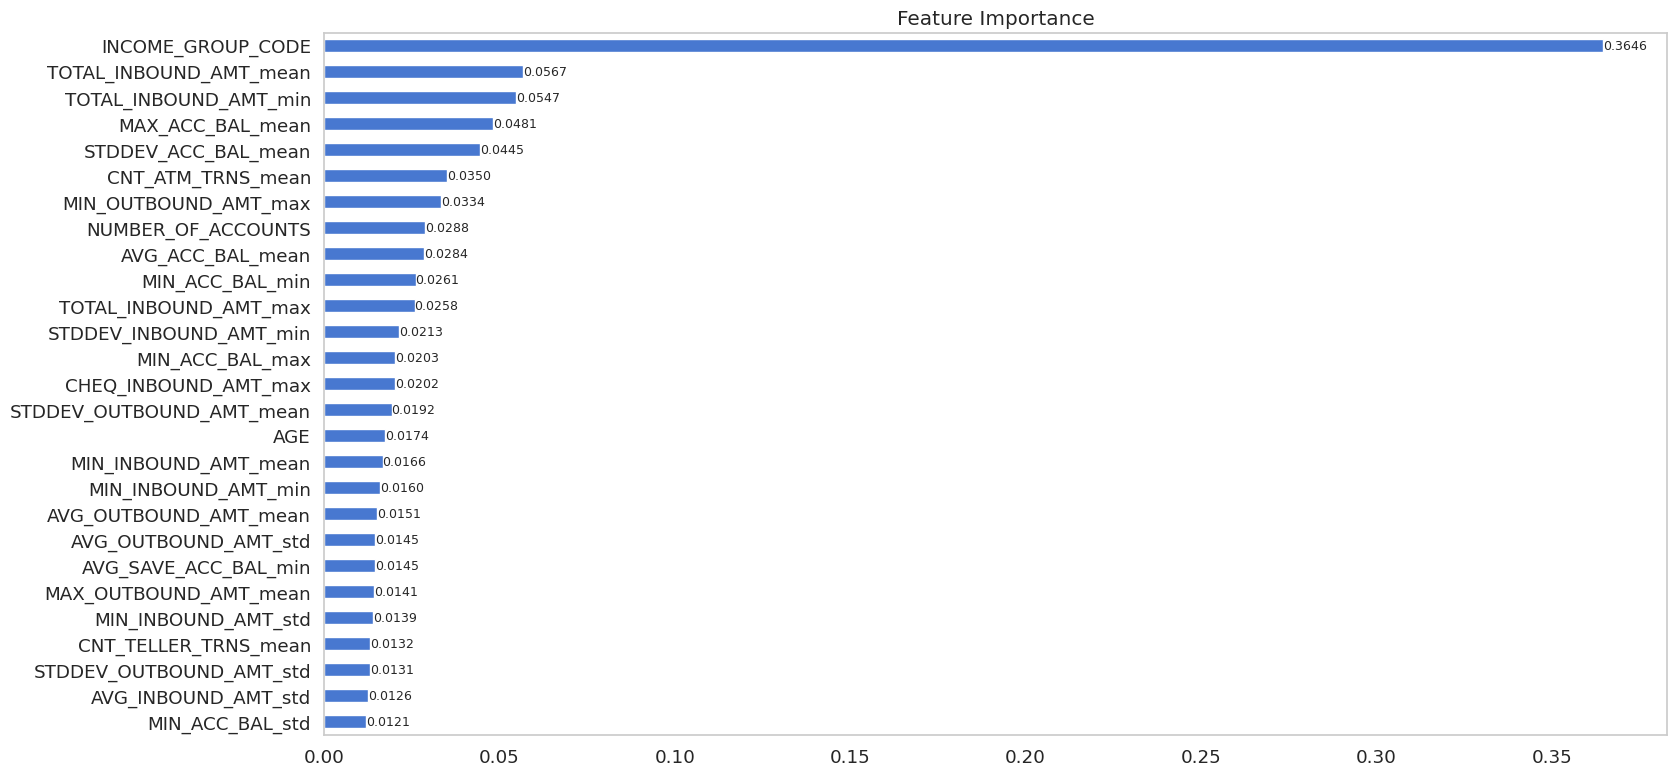

In [147]:
g =  pd.Series(
    dict(zip(X_reduced.columns, best_rf.feature_importances_))
).sort_values()
ax = g.plot(kind='barh')
ax.bar_label(ax.containers[0], fontsize=9, fmt="{:.4f}")
plt.title("Feature Importance")
plt.grid()
plt.tight_layout()
plt.show()

The feature importance analysis reveals that the most significant predictor for declared net income is **INCOME_GROUP_CODE**, which contributes over 36% to the model's predictions. Other important features include transaction amounts such as **TOTAL_INBOUND_AMT_mean** and **TOTAL_INBOUND_AMT_min**, as well as account balance-related metrics like **MAX_ACC_BAL_mean** and **STDDEV_ACC_BAL_mean**. Additionally, **CNT_ATM_TRNS_mean** (mean number of ATM transactions) also plays a notable role.

These findings suggest that customer financial activity, including inbound transactions, account balances, and ATM usage, are critical factors in predicting declared income, with the INCOME_GROUP_CODE being the most influential feature.

#### SHAP Analysis

PermutationExplainer explainer: 487it [2:17:48, 17.01s/it]                         t]


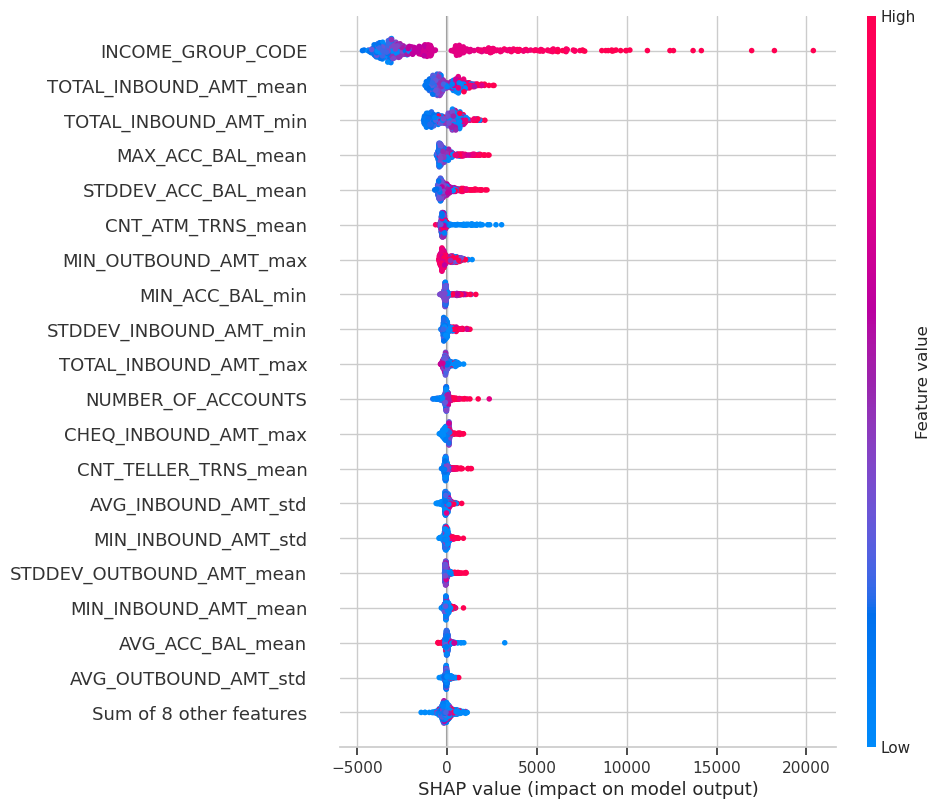

In [ ]:
explainer = shap.Explainer(best_rf.predict, X_train_reduced)
shap_values = explainer(X_val_reduced)
shap.plots.beeswarm(shap_values, max_display=20)

#### Apply model to holdout set

In [135]:
y_pred = best_rf.predict(X_test_reduced)
rmse = root_mean_squared_error(y_test_reduced, y_pred)
print(f"Test RMSE: {rmse:.4f}")
r2 = r2_score(y_test_reduced, y_pred)
print(f"Test r2: {r2:.4f}")

Test RMSE: 6661.8514
Test r2: 0.5724


#### Residual Analysis

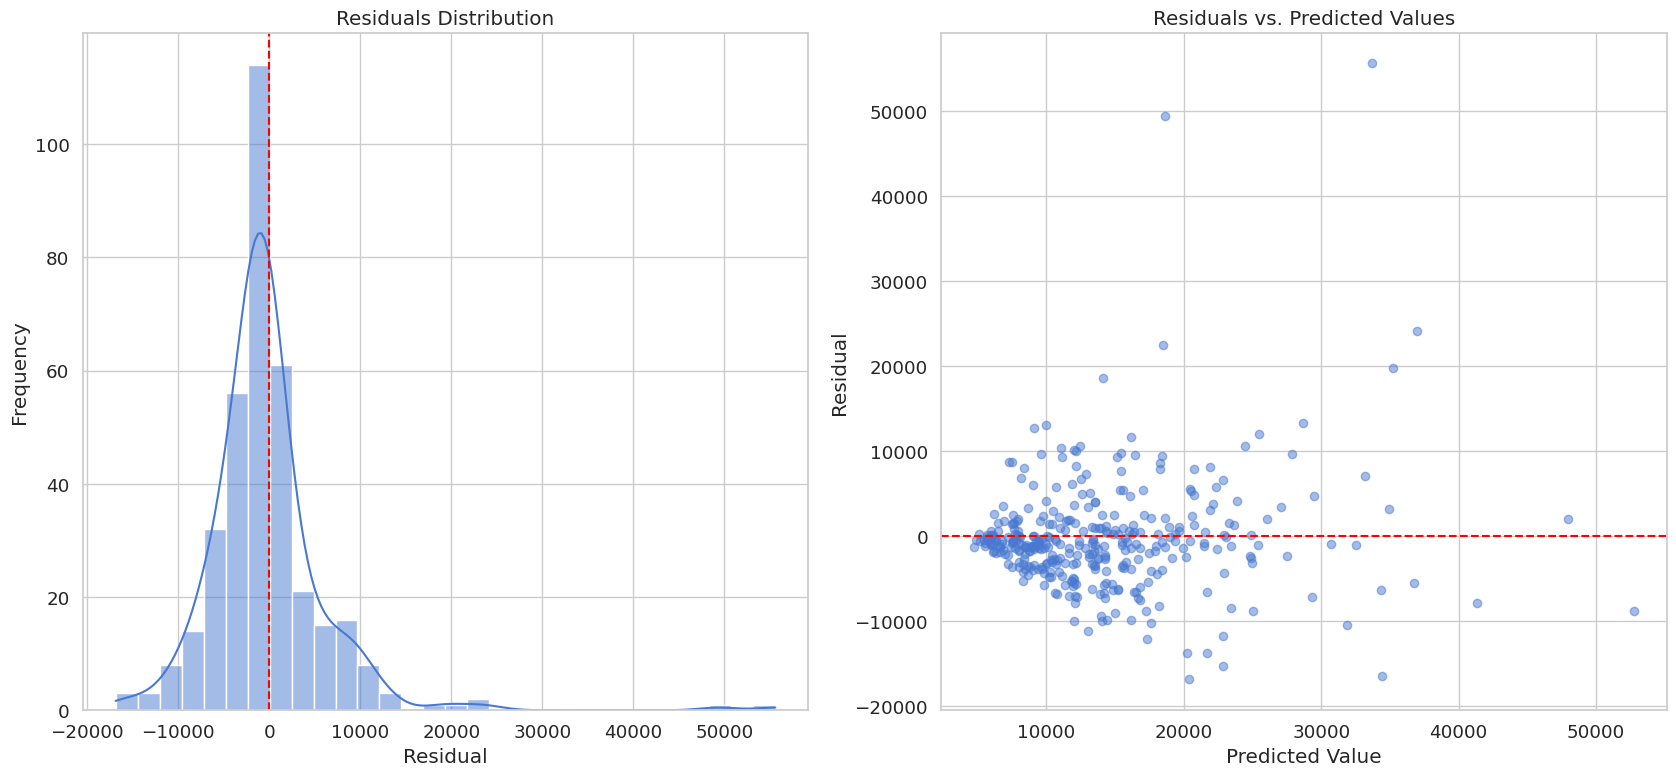

In [136]:
y_pred = best_rf.predict(X_test_reduced)
residuals = y_test_reduced - y_pred

fig, axes = plt.subplots(1, 2, )  # Side by side, no shared x-axis

# Residuals Distribution
sns.histplot(residuals, bins=30, kde=True, ax=axes[0])
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_title("Residuals Distribution")
axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Frequency")

# Residuals vs. Predicted Values
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title("Residuals vs. Predicted Values")
axes[1].set_xlabel("Predicted Value")
axes[1].set_ylabel("Residual")

plt.tight_layout()
plt.show()

The residuals are fairly centred around zero. We do see greater variability in errors made as the predicted value increases.

#### Actual vs Predicted Values

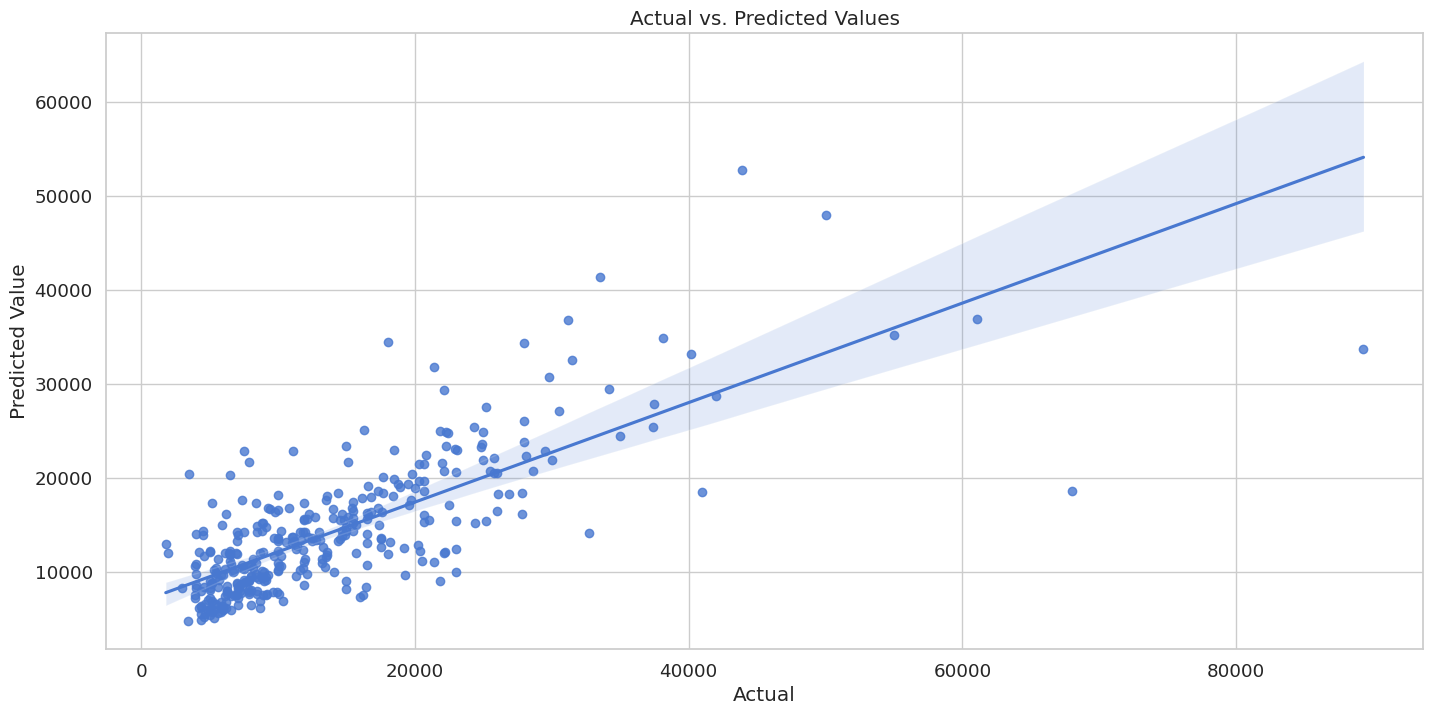

In [137]:
sns.regplot(x=y_test_reduced, y=y_pred, order=1)
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual")
plt.ylabel("Predicted Value")
plt.show()

From the above plot it appears that the model tends to understate the income on the test set.

#### Train Final Model

In [138]:
rf = RandomForestRegressor(**bayes_search.best_params_, random_state=42)
rf.fit(X_reduced,y)

RandomForestRegressor(max_depth=39, max_features='sqrt', min_samples_split=5,
                      n_estimators=3500, random_state=42)

In [139]:
joblib.dump(rf, f"artifacts/rf_model-{datetime.strftime(datetime.now(), '%Y-%m-%d-%H-%M')}.joblib")

['artifacts/rf_model-2025-01-19-15-43.joblib']

####  Submission 

In [140]:
def preprocessing(df):
    out_df = df.merge(customer_df, on='CUSTOMER_IDENTIFIER')
    out_df = out_df.merge(flat_trans_df_cleaned, on="CUSTOMER_IDENTIFIER")
    out_df.set_index(["CUSTOMER_IDENTIFIER", "RECORD_DATE", "DATE_LAST_UPDATED"], inplace=True)
    X = out_df.loc[:, selector.support_]
    return X

In [141]:
test_df = wr.s3.read_csv(os.path.join(input_s3_path, "Test.csv"))

In [142]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1544 entries, 0 to 1543
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CUSTOMER_IDENTIFIER  1544 non-null   object
 1   RECORD_DATE          1544 non-null   object
dtypes: object(2)
memory usage: 24.3+ KB


In [143]:
submission_df = pd.DataFrame(
    {'CUSTOMER_IDENTIFIER': test_df['CUSTOMER_IDENTIFIER'].values,
     'DECLARED_NET_INCOME' : np.round(
         rf.predict(
             preprocessing(test_df)
         ),
         2
     )
    }
)

In [144]:
wr.s3.to_csv(
    submission_df,
    f"{submissions_s3_path}/submission_rf-{datetime.strftime(datetime.now(), '%Y-%m-%d-%H-%M')}.csv",
    index=False)

{'paths': ['s3://sagemaker-us-east-1-770208914484/absa_zindi_challenge/submissions/submission_rf-2025-01-19-15-43.csv'],
 'partitions_values': {}}

#### Useful Links

https://pandas.pydata.org/pandas-docs/version/1.0/user_guide/style.html

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html#sphx-glr-auto-examples-hyperparameter-optimization-py

https://xgboosting.com/configure-xgboost-reggamma-objective/

https://pandas.pydata.org/docs/user_guide/style.html

https://www.run.ai/guides/hyperparameter-tuning/bayesian-hyperparameter-optimization

https://www.geeksforgeeks.org/feature-importance-with-random-forests/

https://scikit-learn.org/1.6/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py